# <p style="text-align: center;"> **Bayesian Analysis of ARPAV time series on temperatures and precipitations**</p>
## <p style="text-align: center;">  Advanced Statistics for Physics Analysis Project - 17 July 2024</p>

*ARPAV* (Agenzia Regionale per la iPrevenzione e Protezione Ambientale del Veneto) is an agency widespread over the territory that collects and analyzes environmental data. Some of the measurement points are quite old and a very long time serie (for example in Cavanis, Venice, daily measurements are available since 1900).
The aim of the project is to analyze the data available in three stations from 1993 to 2021, where the environment is quite different, and study the evolution over time. The stations are located in:<br>
- Auronzo di Cadore ( Lat: *46°33'33"* N, Long: *12°25'28"* E, Alt over sea level: 887 m);<br>
- Castelfranco Veneto ( Lat: *45°40'00"* N, Long: *11°55'00"* E, Alt over sea level: 46 m);<br>
- Porto Tolle ( Lat: *44°56'58"* N, Long: *12°19'28"* E, Alt over sea level: -22 m);<br>
- Roverchiara ( Lat: *45°16'10"* N, Long: *11°14'41"* E, Alt over sea level: 20 m).<br>

We start by importing the necessary R packages.

In [2]:
library(dplyr)
library(readr)
library(lubridate)
library(purrr)
library(tools)
library(ggplot2)
library(gridExtra)
library(stats)
library(R2jags)
library(coda)
library(forecast)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



## **Storing The Dataset**

Next we define some functions to read and store the dataset in dedicated R data frames using the tidyverse tools.

In [66]:
create_dataset <- function(Monthly=FALSE,Yearly=FALSE) {
      
      data_folder <- "./datiarpav"
    
      # Ottenere la lista di tutti i file con estensione .csv
      file_csv <- list.files(path = data_folder, pattern = "*.csv", full.names = TRUE)    
      # Creare un dataframe combinando i dati dai file CSV
      df <- file_csv |>
            map_df(~ read_csv(.x, show_col_types = FALSE) |>
            na.omit() |>
            mutate(file = file_path_sans_ext(basename(.x)),
                   month = ym(format(date, "%Y-%m")),
                   year_only = year(date))) |>
            filter(date >= as.Date('1993-01-01') & date <= as.Date('2021-12-31')) |>
            relocate( month, year_only, file, .after = date) |>
            arrange(date)     

      #Better format the stations' names
      df['file'][[1]]<-case_when(
          str_detect(df['file'][[1]],'Temperatura') == 1 ~ str_replace_all(str_replace_all(str_sub(df['file'][[1]],1,-23),"[:digit:]", ""),"_",""),
          str_detect(df['file'][[1]],'Temperatura') == 0 ~ str_to_lower(str_replace_all(str_replace_all(str_sub(df['file'][[1]],1,-9),"[:digit:]", ""),"_",""))
      )  
    
      # Aggiungere colonne year e month_only
      df <- df |>
            mutate(month_only = as.double(format(month, "%m"))) |>
            relocate(month_only, .after = year_only)

      # dataset con summary mensili
      if(Monthly){
            df <- df |> group_by(month) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> 
                  mutate(year_only = as.double(format(month, "%Y")), month_only = as.double(format(month, "%m")))|>
            relocate(month_only, year_only, .after = month)
      }
      # dataset con summary annuali 
      if(Yearly){
            df <- df |> group_by(year_only) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> mutate(x_fit = year_only - min(year_only))
      }
      
    return(df)
}

# funzione per analizzare singoli mesi 
month_analisis <- function(df, n){
      m_df <- df[df$month_only == n,]
      return(m_df)
}



In [67]:
daily_dataset <- create_dataset()
monthly_dataset <- create_dataset(Monthly =   TRUE) 
yearly_dataset <- create_dataset(Yearly = TRUE)

## **Preliminary Analysis**


We begin our analysis with a preliminary study of the minimum, average and maximum temperatures from month to month (averaging them out on all the available stations)

In [68]:
# monthly heatmap
create_heatmap <- function(df, str, index){
    time_interval = 10              # past months to consider for the difference
    years <- unique(df$year_only)   
    num_years <- length(years)
    heatmap_data <- data.frame()
    
    for (n in 1:12) {
        month_evolution <- month_analisis(df, n)      # estraiamo una summary dei mesi 
        if(names(str)[index] == 'Minimum'){
            month_temp <- month_evolution$MIN_mean     # estraiamo solo la temperatura     
        }  
        else if(names(str)[index] == 'Maximum'){
            month_temp <- month_evolution$MAX_mean     
        }    
        else(names(str)[index] == 'Average')
            month_temp <- month_evolution$MED_mean 
        
        diff <- c()
        
        for (t in (time_interval+1):length(month_temp)) {         # computiamo la differenza tra temperatura di un anno e la media dei 10 anni precedenti
            t_mean <- mean(month_temp[(t-time_interval):(t-1)])
            diff_i <- month_temp[t] - t_mean
            diff <- c(diff, diff_i)
        }
        
        temp_df <- data.frame(                        # costruiamo la heatmap 
            Month = rep(n, length(diff)),
            Year = month_evolution$year_only[(time_interval+1):length(month_temp)],
            Difference = diff
        )
        heatmap_data <- rbind(heatmap_data, temp_df)
    }
    
    # plot 
    heatmap_plot <- ggplot(heatmap_data, aes(x = Year, y = Month, fill = Difference)) +
        geom_tile() +
        scale_fill_gradient2(low = "navy", mid = "white", high = "orange", midpoint = 0) +
        labs(title = paste(names(str)[index], "Monthly T. difference w.r.t. 10 years before"),
             x = "Year",
             y = "Month",
             fill = "Difference") +
        theme_bw()+
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


    return(list(heatmap_plot, heatmap_data, mean(heatmap_data$Difference),var(heatmap_data$Difference)))
}

#Temperature difference distribution
norm_plot <- function(mean,var,type,index){
  x_axis = seq(-5,5,0.001)
  dist = dnorm(x=x_axis,sd = sqrt(var), mean = mean)
  df <- data.frame(x = x_axis, y = dist)
  p <- ggplot(df, aes(x = x, y = y)) + 
  geom_line(color = type[[index]], linewidth = 2) + 
  geom_vline(aes(xintercept = mean), linetype = 2) +
  theme_bw()+
  labs(title = paste(names(type)[index],'Temperature Difference Distribution '),
       x = 'Temperature (°C)',
       y = 'Density') + 
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
 return (p)
}

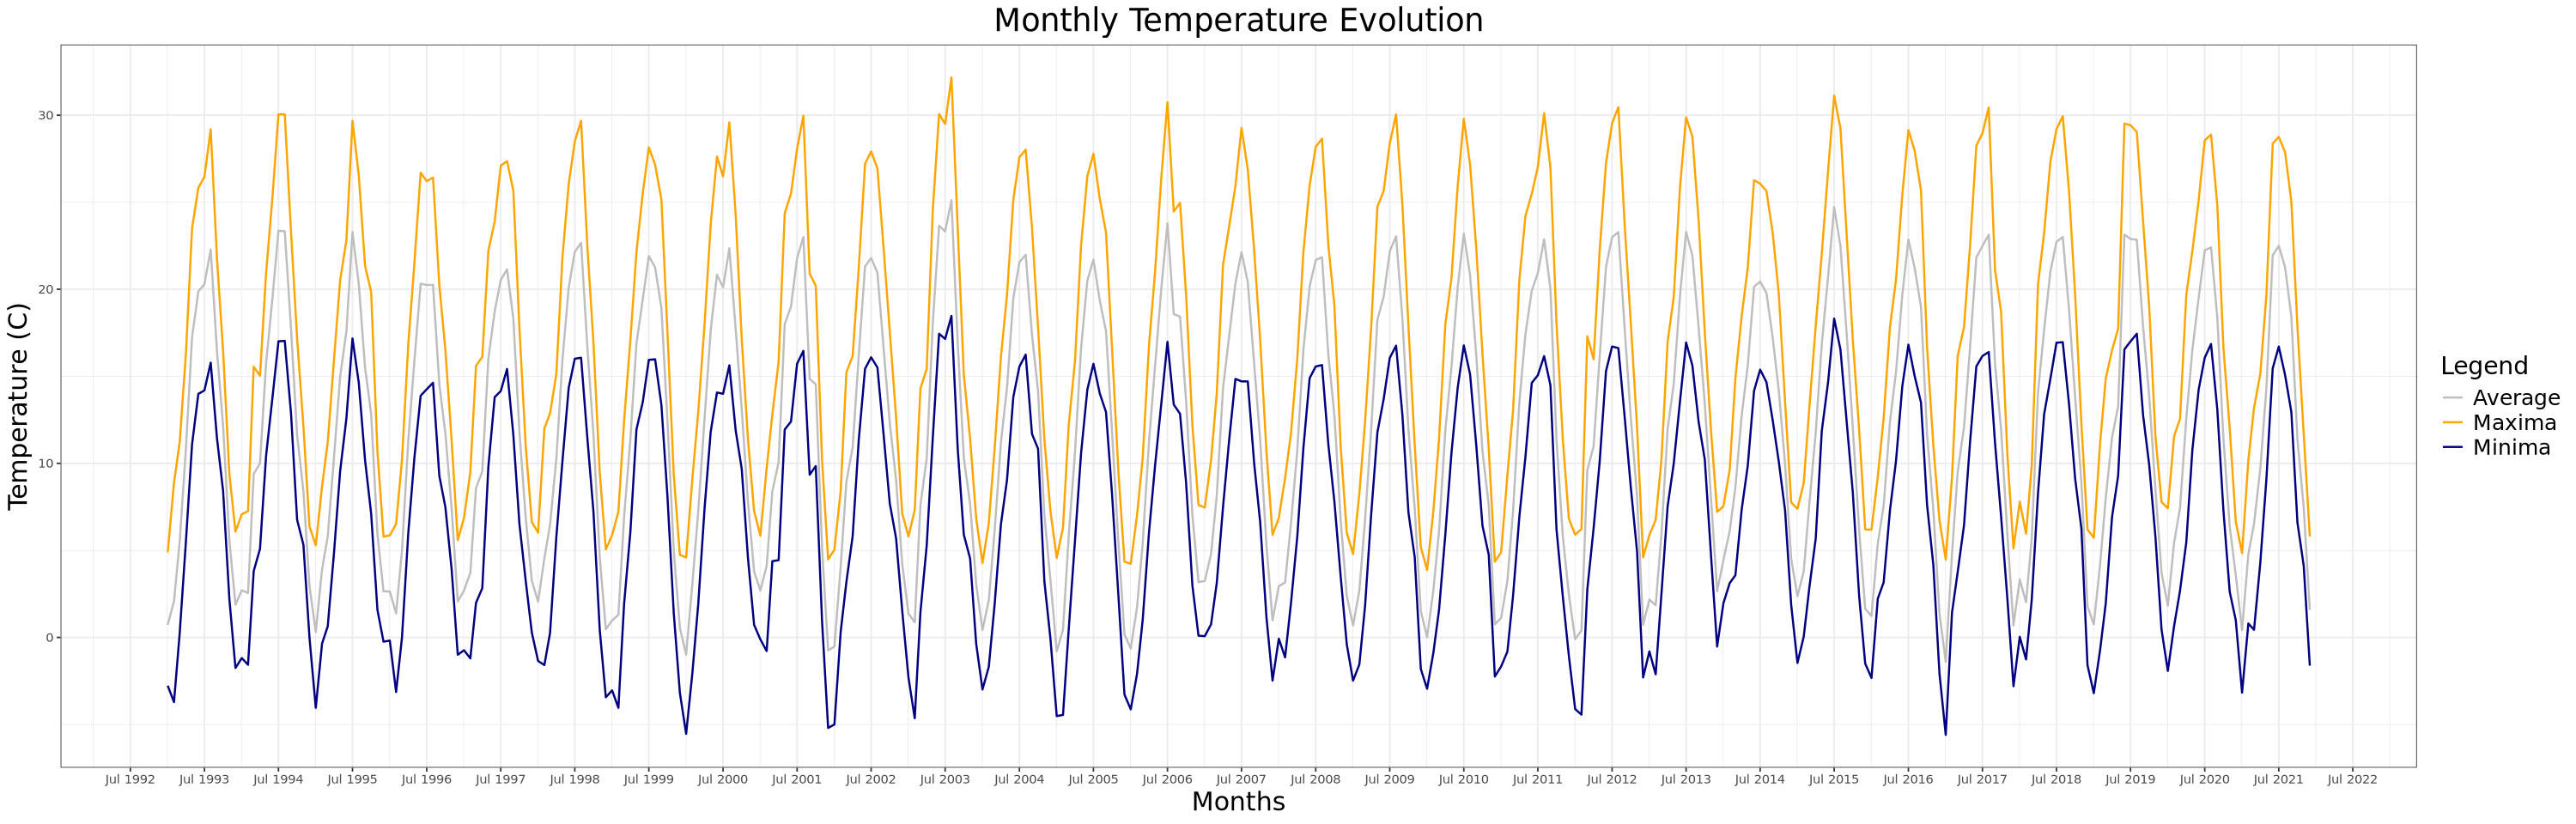

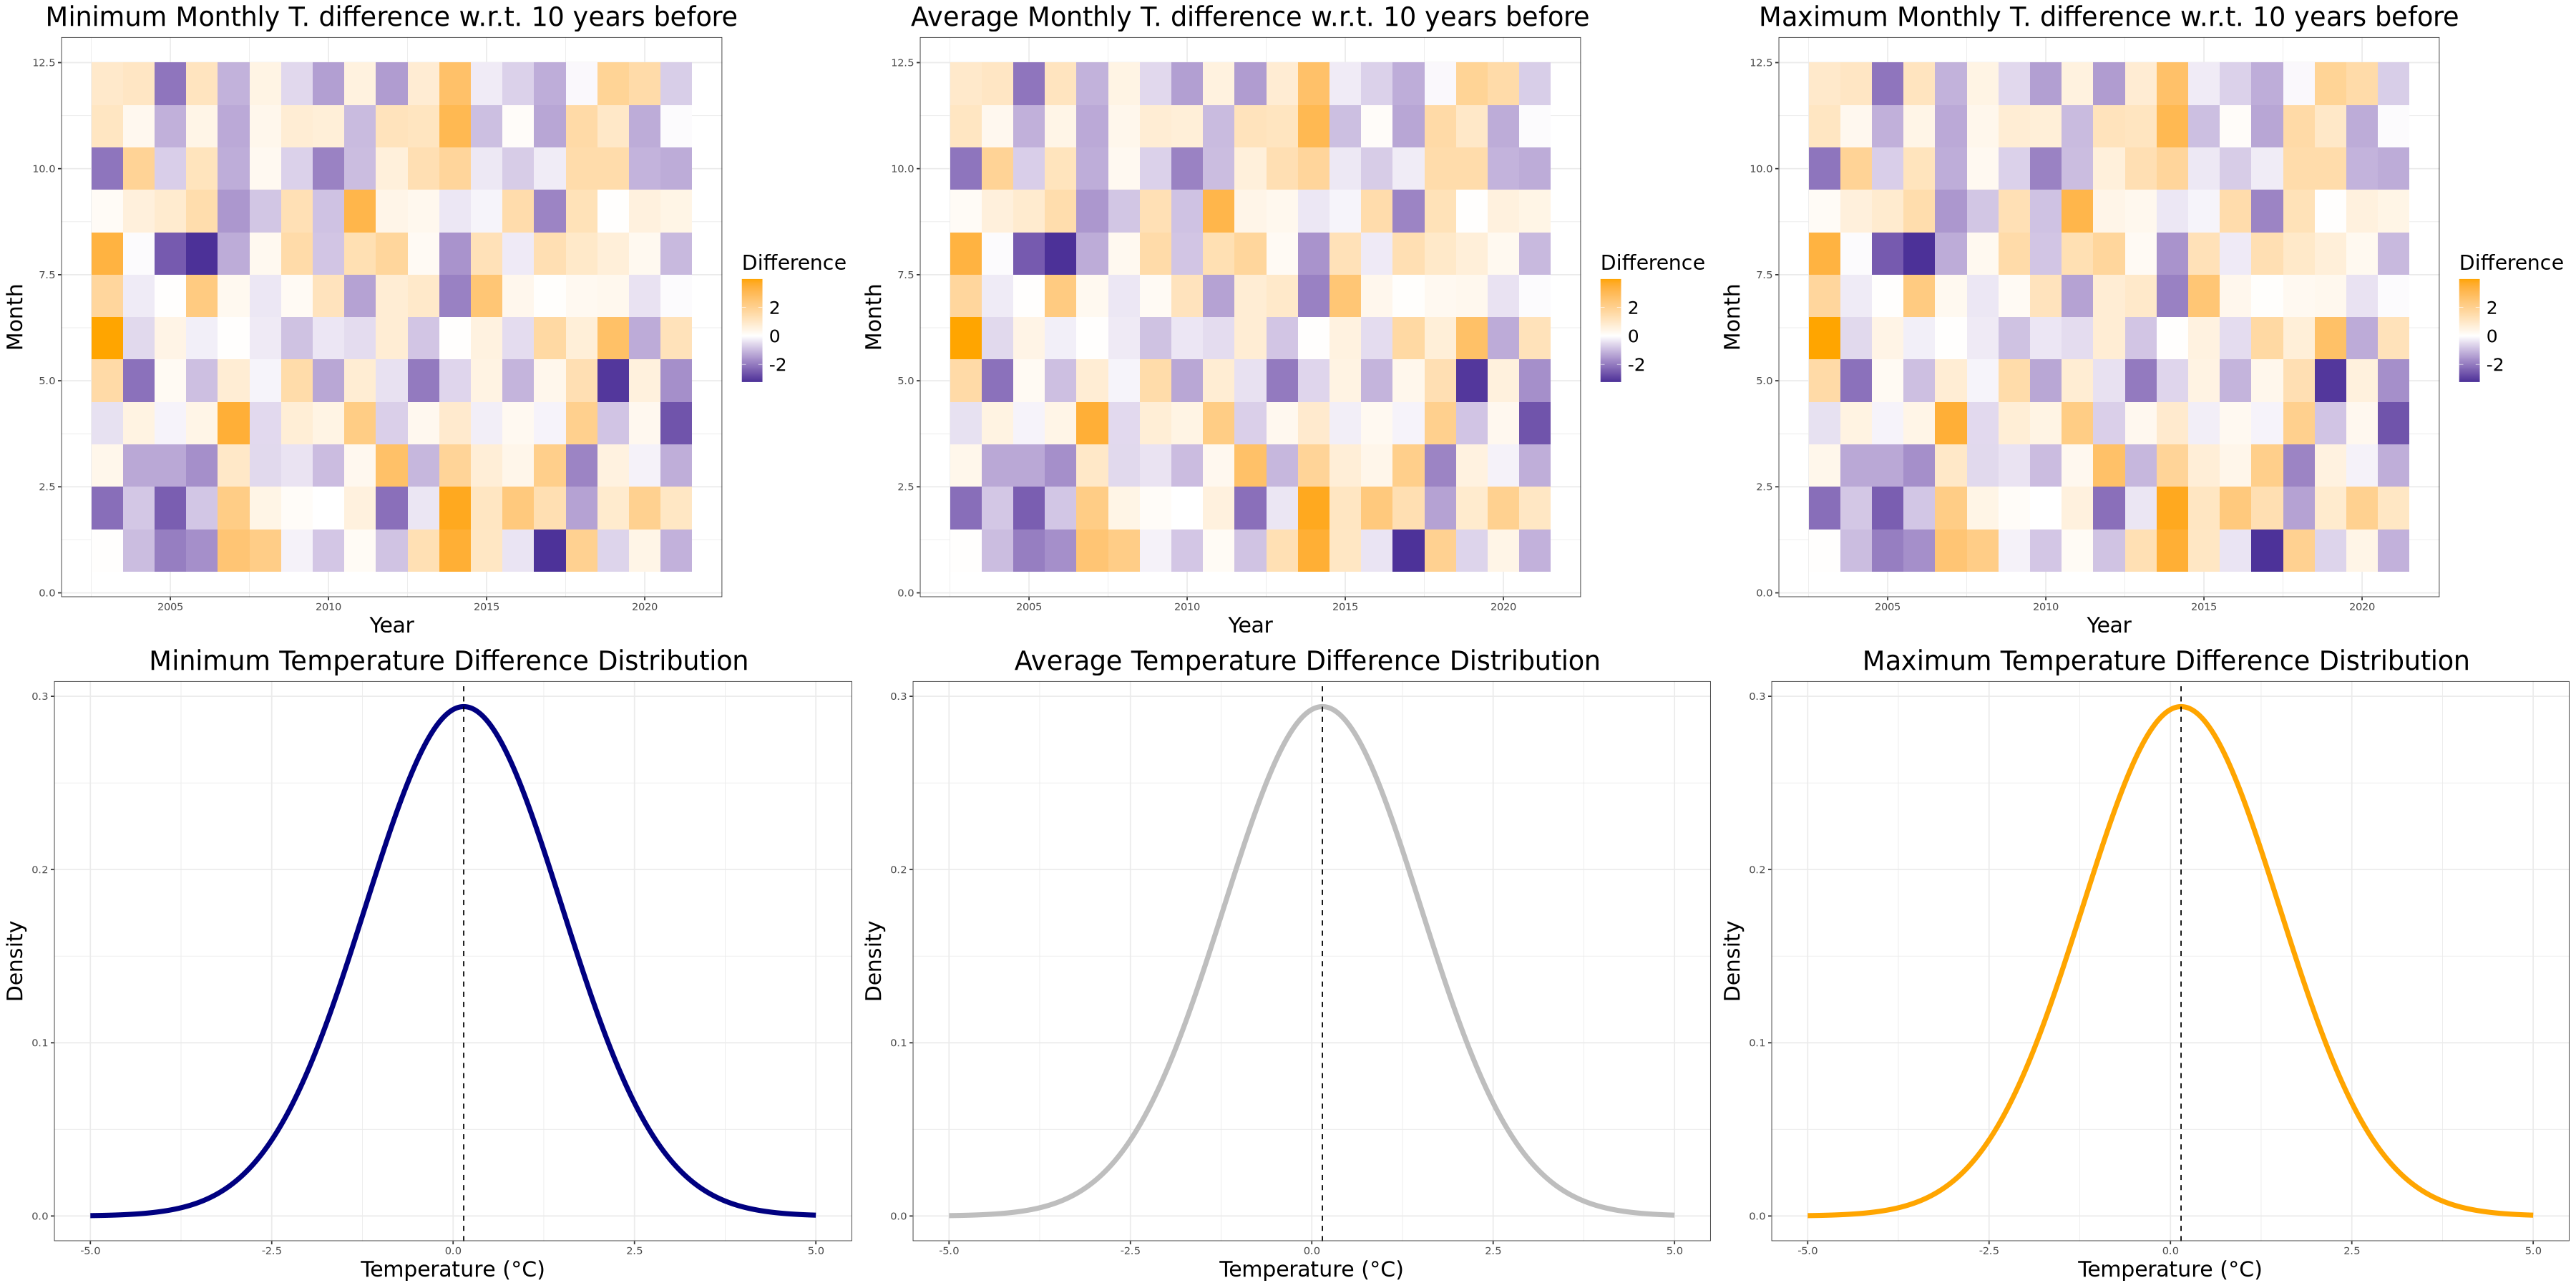

In [69]:
# Setting plot size
options(repr.plot.width = 25, repr.plot.height = 8)

# Monthly Plot
p_m <- ggplot(data = monthly_dataset) +
  geom_line(aes(x = month, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Monthly Temperature Evolution',
       x = 'Months',
       y = 'Temperature (C)') +
  scale_x_date(date_breaks = "12 month", date_labels = "%b %Y") +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

print(p_m)

par<-c('Minimum'='navy','Average'='gray','Maximum'='orange')
#Heatmap creation
h_min <- create_heatmap(df = monthly_dataset, str = par,index=1)
h_ava <- create_heatmap(df = monthly_dataset, str = par,index=2)
h_max <- create_heatmap(df = monthly_dataset, str = par,index=3)


#Normal plotting
plot_min <- norm_plot(h_min[[3]],h_min[[4]],type=par,index=1)
plot_ava <- norm_plot(h_ava[[3]],h_ava[[4]],type=par,index=2)
plot_max <- norm_plot(h_max[[3]],h_max[[4]],type=par,index=3)

options(repr.plot.width = 30, repr.plot.height = 15)
grid.arrange(h_min[[1]], h_ava[[1]], h_max[[1]], 
             plot_min, plot_ava, plot_max, 
             ncol = 3, nrow = 2)

It is clear that we cannot be sure at all that an increasing trend is present, as even if the mean is positive the variance is too big to tell.<br> Further statistical investigations are neede to assess the time series trend.

## **Annual Average Evolution Analysis**

We proceed the analysis with an annual average approach, namely averagin out the temperatures over each year and looking at the trend we find.

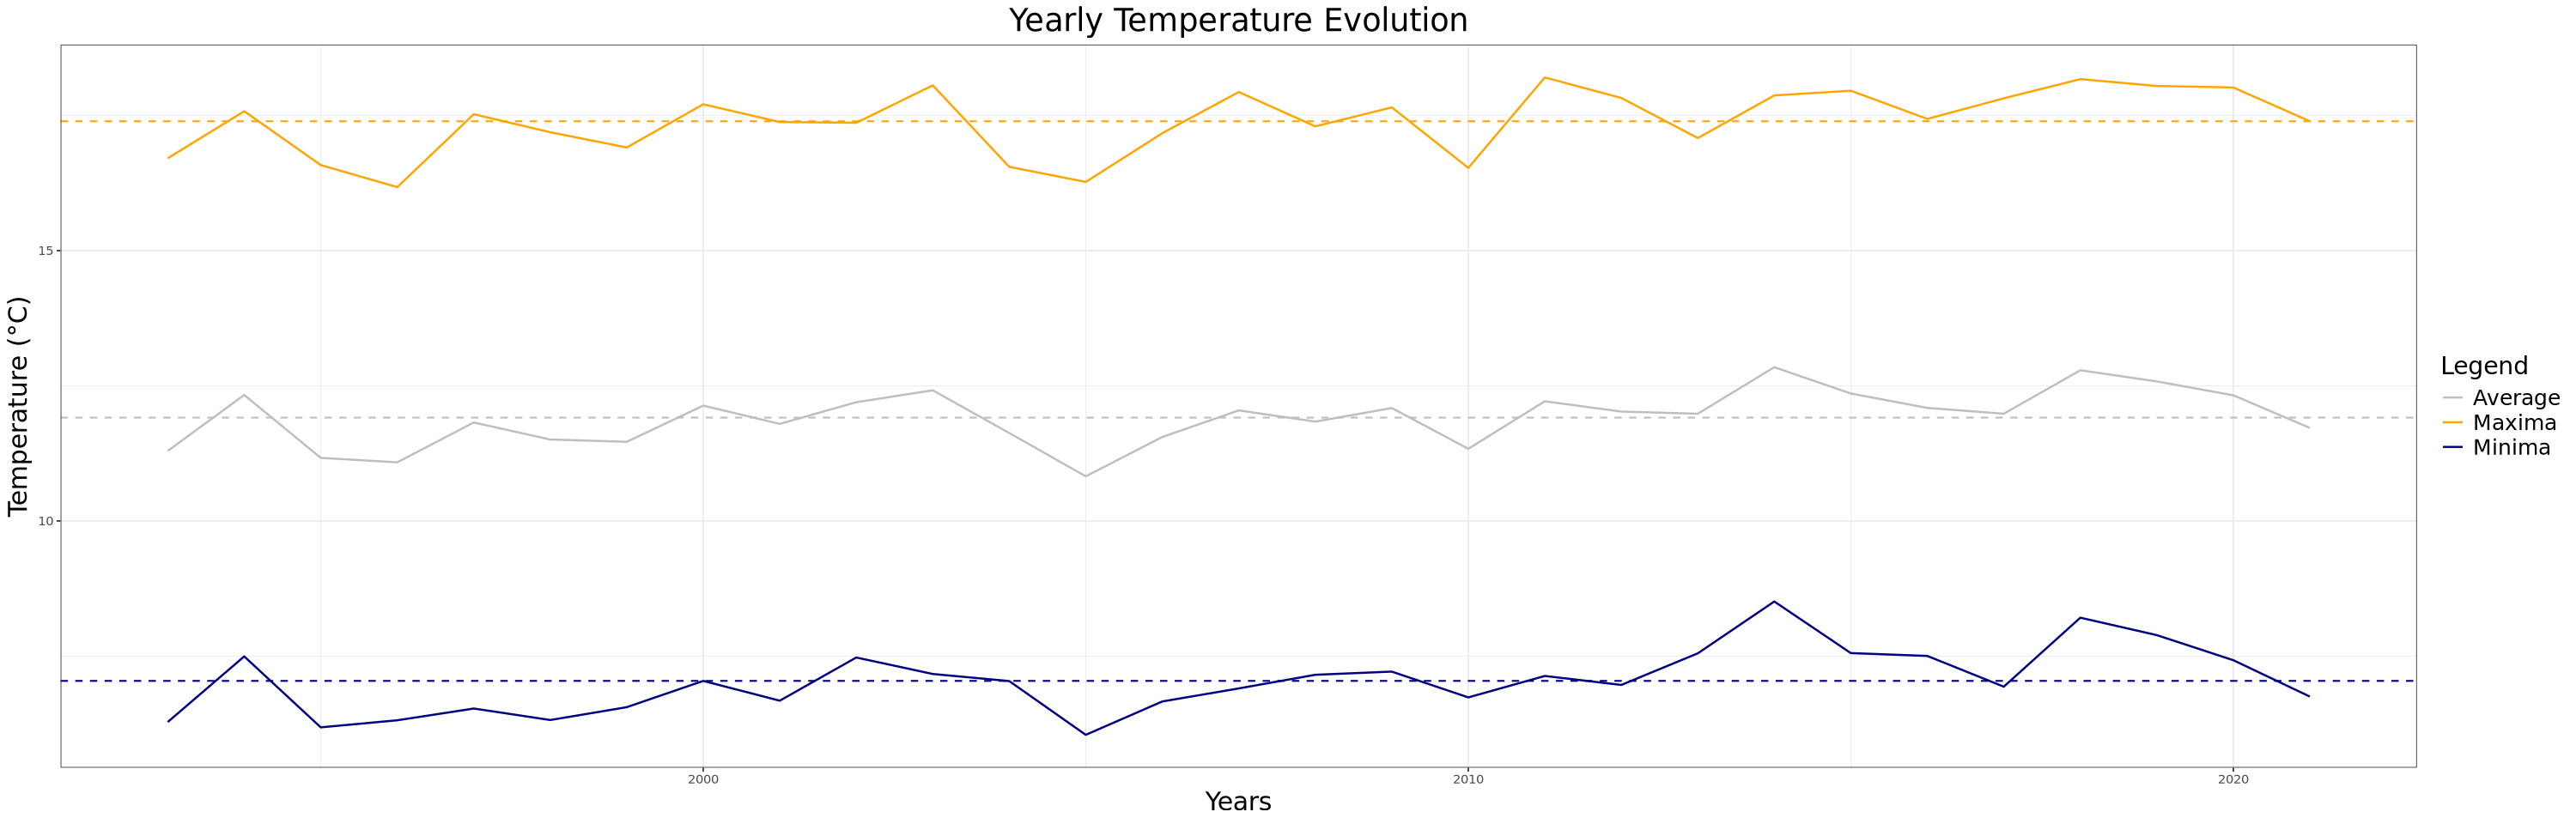

In [70]:
options(repr.plot.width = 25, repr.plot.height = 8)
# Annual Trend
p_y <- ggplot(data = yearly_dataset) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (°C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

print(p_y)

A slight rising trend can be observed, particularly for the minima. We try to compare it with a constant and linear regression models by using the fitting tools provided in the *stats* package.

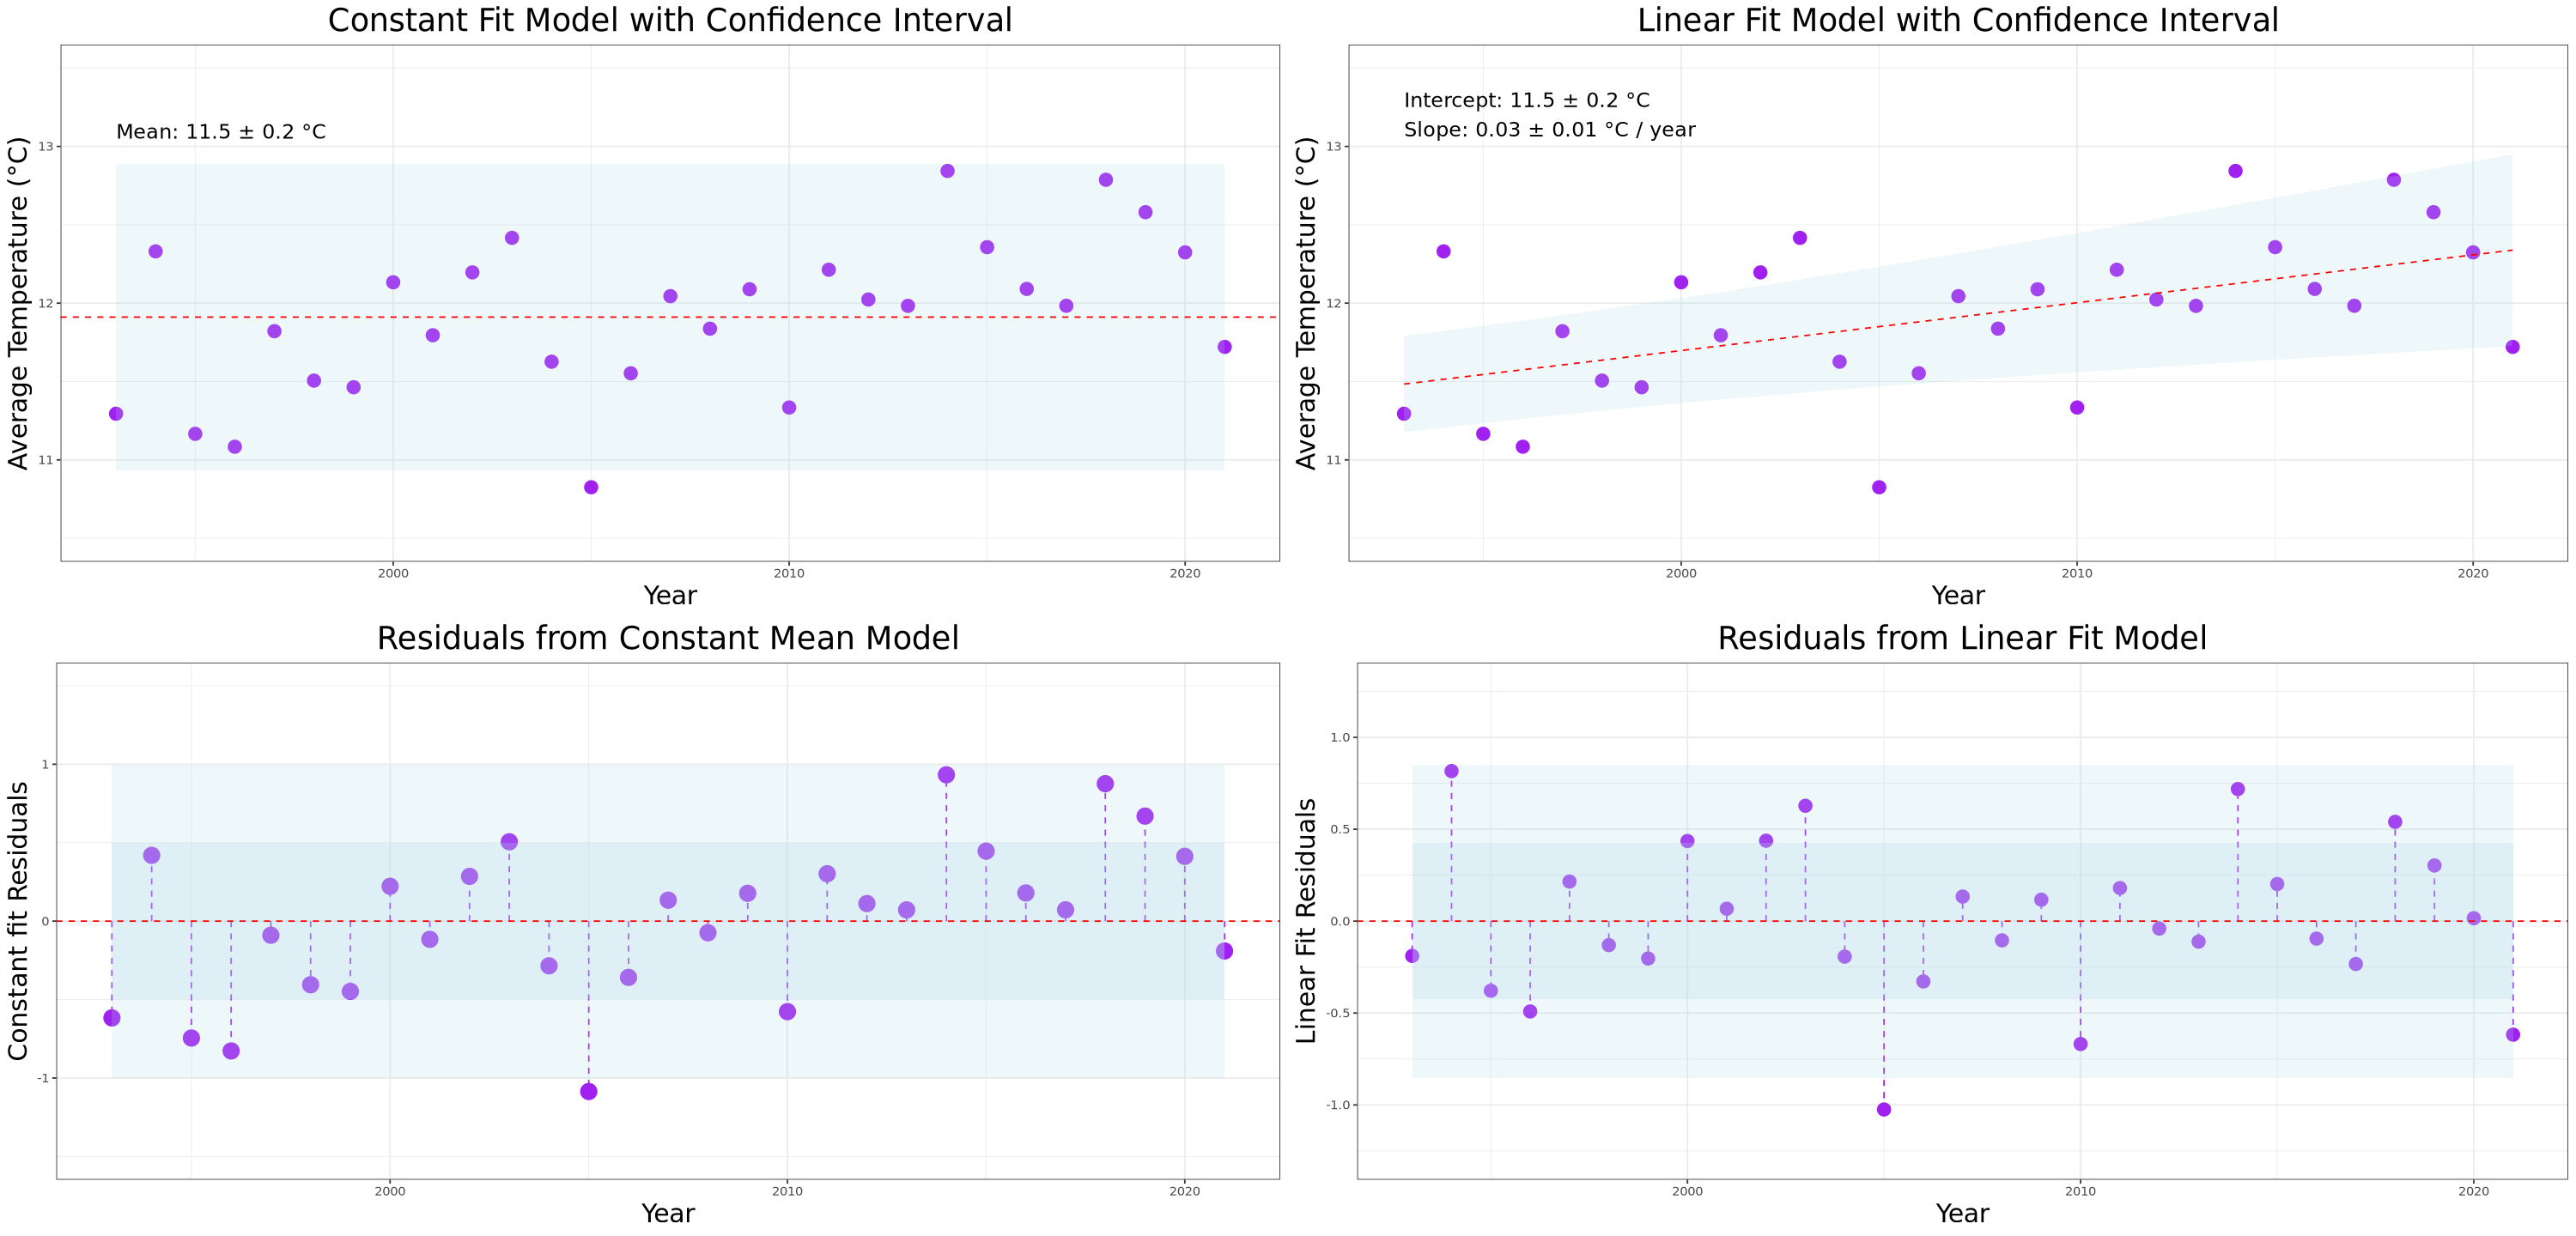

In [71]:
model <- lm(MED_mean ~ x_fit, data = yearly_dataset)
model_summary <- summary(model)
model_coeff_err <- coef(model_summary)[, "Std. Error"]
model_coeff <- coef(model_summary)[, 'Estimate']


fit_dataframe <- yearly_dataset |>
  select(year_only, MED_mean) |>
  mutate(linear_residuals = model$residuals) |>
  mutate(const_residuals = MED_mean - mean(MED_mean)) |>
  mutate(fitted_linear = model$fitted.values)

fit_dataframe <- fit_dataframe |>
  mutate(conf_lower = fitted_linear - 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2),
         conf_upper = fitted_linear + 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2)) |>
  mutate(x_fit = yearly_dataset$x_fit)


#constant_fit_text <- paste0("mean: ", round(mean(yearly_dataset$MED_mean), 1), 
                           # "\nsd: ", round(sqrt(var(yearly_dataset$MED_mean)), 1))
constant_fit_text <- paste0("Mean: ", round(model_coeff[1], 1), ' \u00B1 ', round(model_coeff_err[1], 1),' °C')

p_a <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = mean(MED_mean) - 1.96*sqrt(var(MED_mean)), 
                  ymax = mean(MED_mean) + 1.96*sqrt(var(MED_mean))), 
              alpha = 0.2, fill = 'lightblue') +
  geom_hline(aes(yintercept = mean(MED_mean)), linetype = 2, color = 'red') +
  theme_minimal() +
  ylim(10.5, 13.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.3, 
           label = constant_fit_text, hjust = 0, vjust = 1, size = 5, color = 'black') +
  labs(title = "Constant Fit Model with Confidence Interval",
       x = "Year",
       y = "Average Temperature (°C)")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


linear_fit_text <- paste0("Intercept: ", round(model_coeff[1], 1), ' \u00B1 ', round(model_coeff_err[1], 1),' °C', 
                          "\nSlope: ", round(model_coeff[2], 2), ' \u00B1 ', round(model_coeff_err[2], 2),' °C / year')

p_b <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = conf_lower, ymax = conf_upper), alpha = 0.2, fill = 'lightblue') +
  geom_line(aes(x = year_only, y = fitted_linear), linetype = 2, col = 'red') +
  theme_minimal() +
  ylim(10.5, 13.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = linear_fit_text, hjust = 0, vjust = 1, size = 5, color = "black") +
  labs(title = "Linear Fit Model with Confidence Interval",
       x = "Year",
       y = "Average Temperature (°C)")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

p_c <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = const_residuals), col = 'purple', size = 5) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = const_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = 2*sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2*sqrt(var(MED_mean)), ymax = 3*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2*sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3*sqrt(var(MED_mean)), ymax = -2*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Constant Mean Model",
       x = "Year",
       y = "Constant fit Residuals")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


p_d <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = linear_residuals), col = 'purple', size = 4) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = linear_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = 2 * sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2 * sqrt(var(linear_residuals)), ymax = 3 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2 * sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3 * sqrt(var(linear_residuals)), ymax = -2 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Linear Fit Model",
       x = "Year",
       y = "Linear Fit Residuals")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

options(repr.plot.width = 25, repr.plot.height = 12)


grid.arrange(p_a, p_b, p_c, p_d, 
             ncol = 2, nrow = 2)


From these initial fits, and particularly from their residuals, we can see that a linear trend appears to be more likely, as the residuals for the linear models appear to be more random, whereas we can see a slight rising trend in the ones from the constant model.<br>
The next step is to perform these fits once again this time simulating the parameters using a Monte Carlo Markov Chain with the *r-jags* package. 

In [72]:
init_variables <- function(model_name) {
    if (model_name == "lin_model") {
        return( list(a_min = runif(1, -20, 20), b_min = runif(1, -0.5, 0.5), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), b_max = runif(1, -0.5, 0.5), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), b_ava = runif(1, -0.5, 0.5), sigma_ava = runif(1, 0, 0.8)))
    } else if (model_name == "const_model") {
        return( list(a_min = runif(1, -20, 20), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), sigma_ava = runif(1, 0, 0.8)))
    }
}

regression <- function(df, model_file, params) {
    data <- df %>% select(x_fit, MAX_mean, MIN_mean, MED_mean)
    inits <- init_variables(gsub(".jags", "", model_file))
    jm <- jags.model(model_file, data, inits, n.chains = 1, n.adapt = 1000)
    update(jm, n.iter = 50000)
    chain <- coda.samples(jm, params, n.iter = 1e6, thin = 20)
    return(chain)
}

# modificato bene 
density_plot<- function(chain, type, temp){
    options(repr.plot.width = 20, repr.plot.height = 6)
    chain_df <- as.data.frame(as.mcmc(chain)) 
    quantiles <- summary(chain)$quantiles[,c('2.5%','97.5%')]

    a <- paste('a_', temp, sep='')
    b <- paste('b_', temp, sep='')
    sigma <- paste('sigma_', temp, sep='')
    
    lower_a <- quantiles[a, '2.5%']
    upper_a <- quantiles[a, '97.5%']
    plot_a <- ggplot(chain_df, aes_string(x = a)) +
        geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
        geom_vline(aes_string(xintercept = sprintf('mean(%s)', a)), linetype = 2) +
        geom_vline(aes(xintercept = lower_a), color = 'red') +
        geom_vline(aes(xintercept = upper_a), color = 'red') +
        labs(title = paste("Posterior Distribution of a"),
             x = 'a',
             y = "Density") +
        theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
 

    lower_sigma <- quantiles[sigma, '2.5%']
    upper_sigma <- quantiles[sigma, '97.5%']
    plot_sigma <- ggplot(chain_df, aes_string(x = sigma)) +
        geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
        geom_vline(aes(xintercept = lower_sigma), color = 'red') +
        geom_vline(aes(xintercept = upper_sigma), color = 'red') +
        geom_vline(aes_string(xintercept = sprintf('mean(%s)', sigma)), linetype = 2) +
        labs(title = paste("Posterior Distribution of sigma"),
             x = 'sigma',
             y = "Density") +
        theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


    if(type == 'linear'){

        lower_b <- quantiles[b, '2.5%']
        upper_b <- quantiles[b, '97.5%']
        plot_b <- ggplot(chain_df, aes_string(x = b)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            geom_vline(aes(xintercept = lower_b), color = 'red') +
            geom_vline(aes(xintercept = upper_b), color = 'red') +
            geom_vline(aes_string(xintercept = sprintf('mean(%s)', b)), linetype = 2) +
            labs(title = paste("Posterior Distribution of b"),
                 x = 'b',
                 y = "Density") +
            theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

        return(grid.arrange(plot_a, plot_b, plot_sigma, ncol = 3, nrow = 1))
    } else {
        return(grid.arrange(plot_a, plot_sigma, ncol = 2, nrow = 1))
    }
}


trace_plot <- function(chain, type, temp) {
    options(repr.plot.width = 20, repr.plot.height = 8)
    chain_df <- as.data.frame(as.mcmc(chain)) 
    chain_df$iteration <- 1:length(chain_df[,1])

    a <- paste('a_', temp, sep='')
    b <- paste('b_', temp, sep='')
    sigma <- paste('sigma_', temp, sep='')
      
    if(type == 'linear'){
        
        plot_a <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df), y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

        plot_sigma <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df),  y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
        options(repr.plot.width = 25, repr.plot.height = 7)

        if(type == 'linear'){
            plot_b <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df),  y = b)) +
                geom_line(alpha = 0.9, color = 'lightblue') +
                labs(title = paste("Trace Plot of b"),
                    x = "Iteration",
                    y = 'b') +
                theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
            return(grid.arrange(plot_a, plot_b, plot_sigma, ncol = 3, nrow = 1))       
        }
        else {
            return(grid.arrange(plot_a, plot_sigma, ncol = 2, nrow = 1))
        }
    }
}


get_model_parameters <- function(chain, type, temp) {
    if(temp == 'min'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_min), b = mean(chain_df$b_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min), sd_b = sd(chain_df$b_min), sd_sigma= sd(chain_df$sigma_min) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min),  sd_sigma= sd(chain_df$sigma_min) ) 
            return(parameters)
        }
    }
    else if(temp == 'max'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_max), b = mean(chain_df$b_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max), sd_b = sd(chain_df$b_max), sd_sigma= sd(chain_df$sigma_max) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max),  sd_sigma= sd(chain_df$sigma_max) ) 
            return(parameters)
        }
    }
    else if(temp == 'ava'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_ava), b = mean(chain_df$b_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava), sd_b = sd(chain_df$b_ava), sd_sigma= sd(chain_df$sigma_ava) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava),  sd_sigma= sd(chain_df$sigma_ava) ) 
            return(parameters)
        }
    }        
}

get_model_prediction <- function(chain, dataset, type, temp){

    if(type == 'linear'){
        parameters <- get_model_parameters(chain,type = 'linear', temp)
        y_pred <- parameters$a + (parameters$b * dataset$x_fit)        
    }
    else if(type == 'constant'){
        parameters <- get_model_parameters(chain,type = 'constant', temp)
        y_pred <- rep(parameters$a, length(dataset$x_fit))
    }
    return(y_pred)
}

get_model_likelihood <- function(chain, dataset, type, temp){
    param <- get_model_parameters(chain, type, temp)
    pred <- get_model_prediction(chain, dataset, type, temp)

    if(temp == 'min'){
        obs <- dataset$MIN_mean
    }
    else if(temp == 'max'){
        obs <- dataset$MAX_mean
    }
    else if(temp == 'ava'){
        obs <- dataset$MED_mean
    }
    return(-((log(param$sigma) * length(pred)) + sum(((obs - pred) / (sqrt(2) * param$sigma))^2)))
}


In [73]:
# Parametri per i modelli
lin_model_file <- "lin_model.jags"
lin_pars <- c("a_min", "b_min", "sigma_min", "a_max", "b_max", "sigma_max", "a_ava", "b_ava", "sigma_ava")

const_model_file <- "const_model.jags"
const_pars <- c("a_min", "sigma_min", "a_max", "sigma_max", "a_ava", "sigma_ava")

In [74]:
lin_chain <- regression(yearly_dataset, lin_model_file, lin_pars)
const_chain <- regression(yearly_dataset, const_model_file, const_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 87
   Unobserved stochastic nodes: 9
   Total graph size: 312

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 87
   Unobserved stochastic nodes: 6
   Total graph size: 133

Initializing model



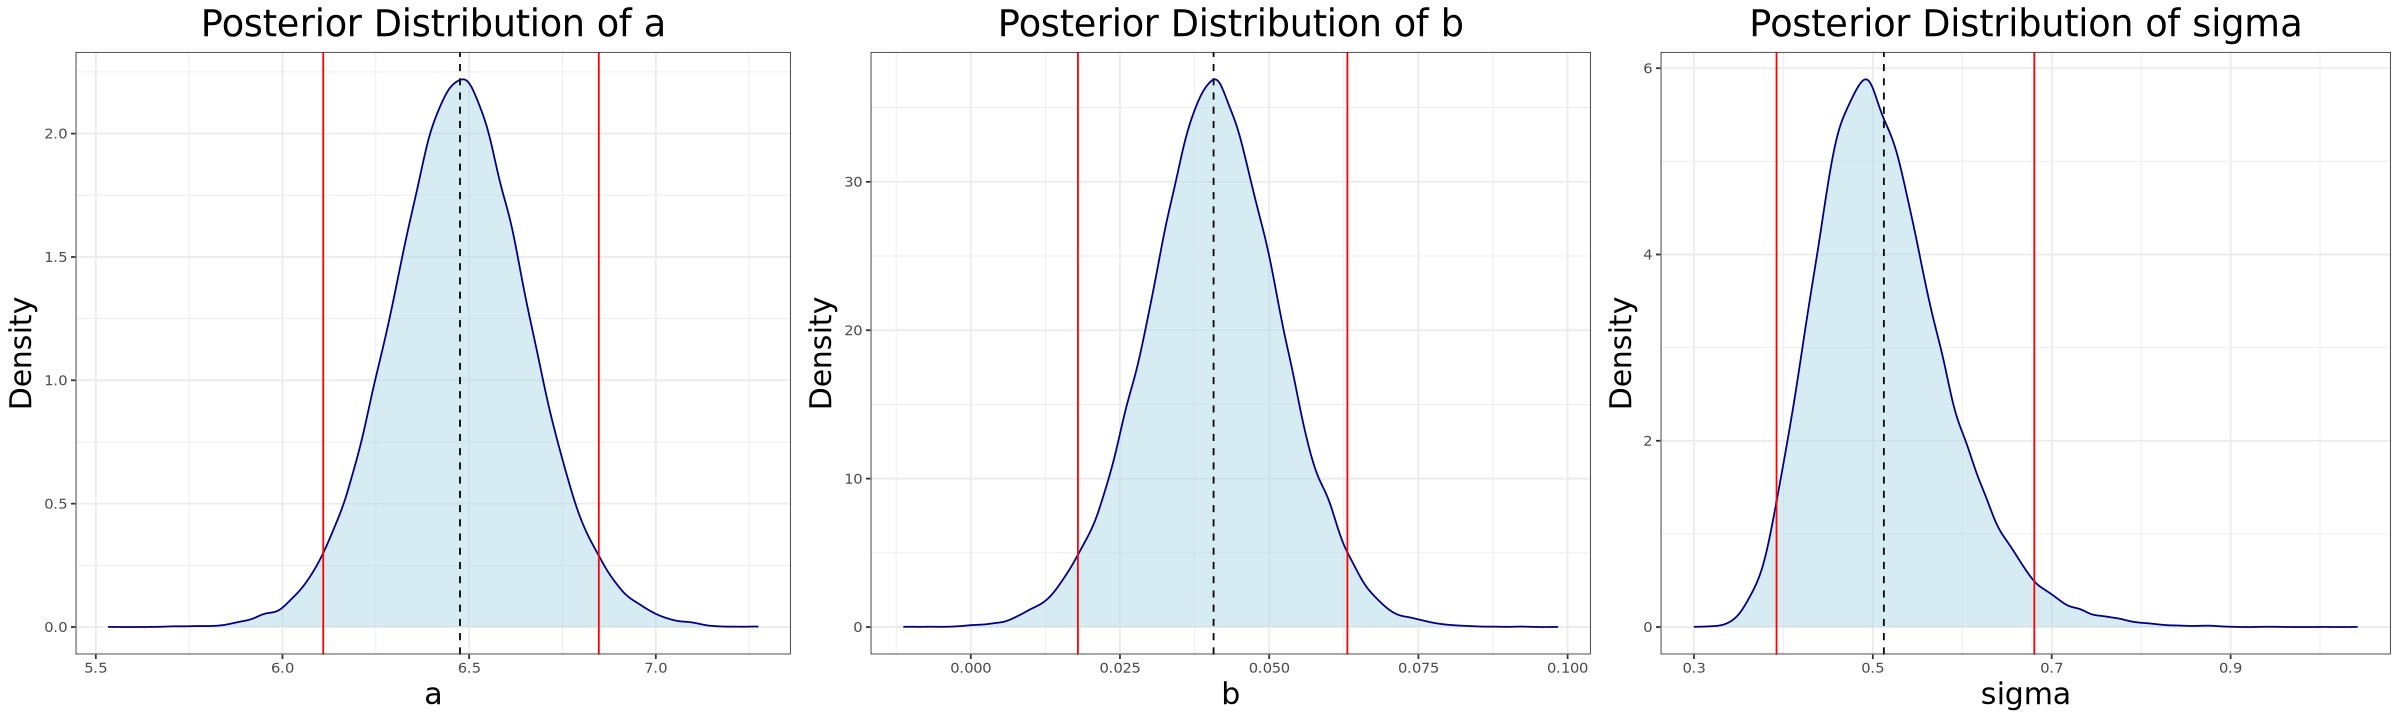

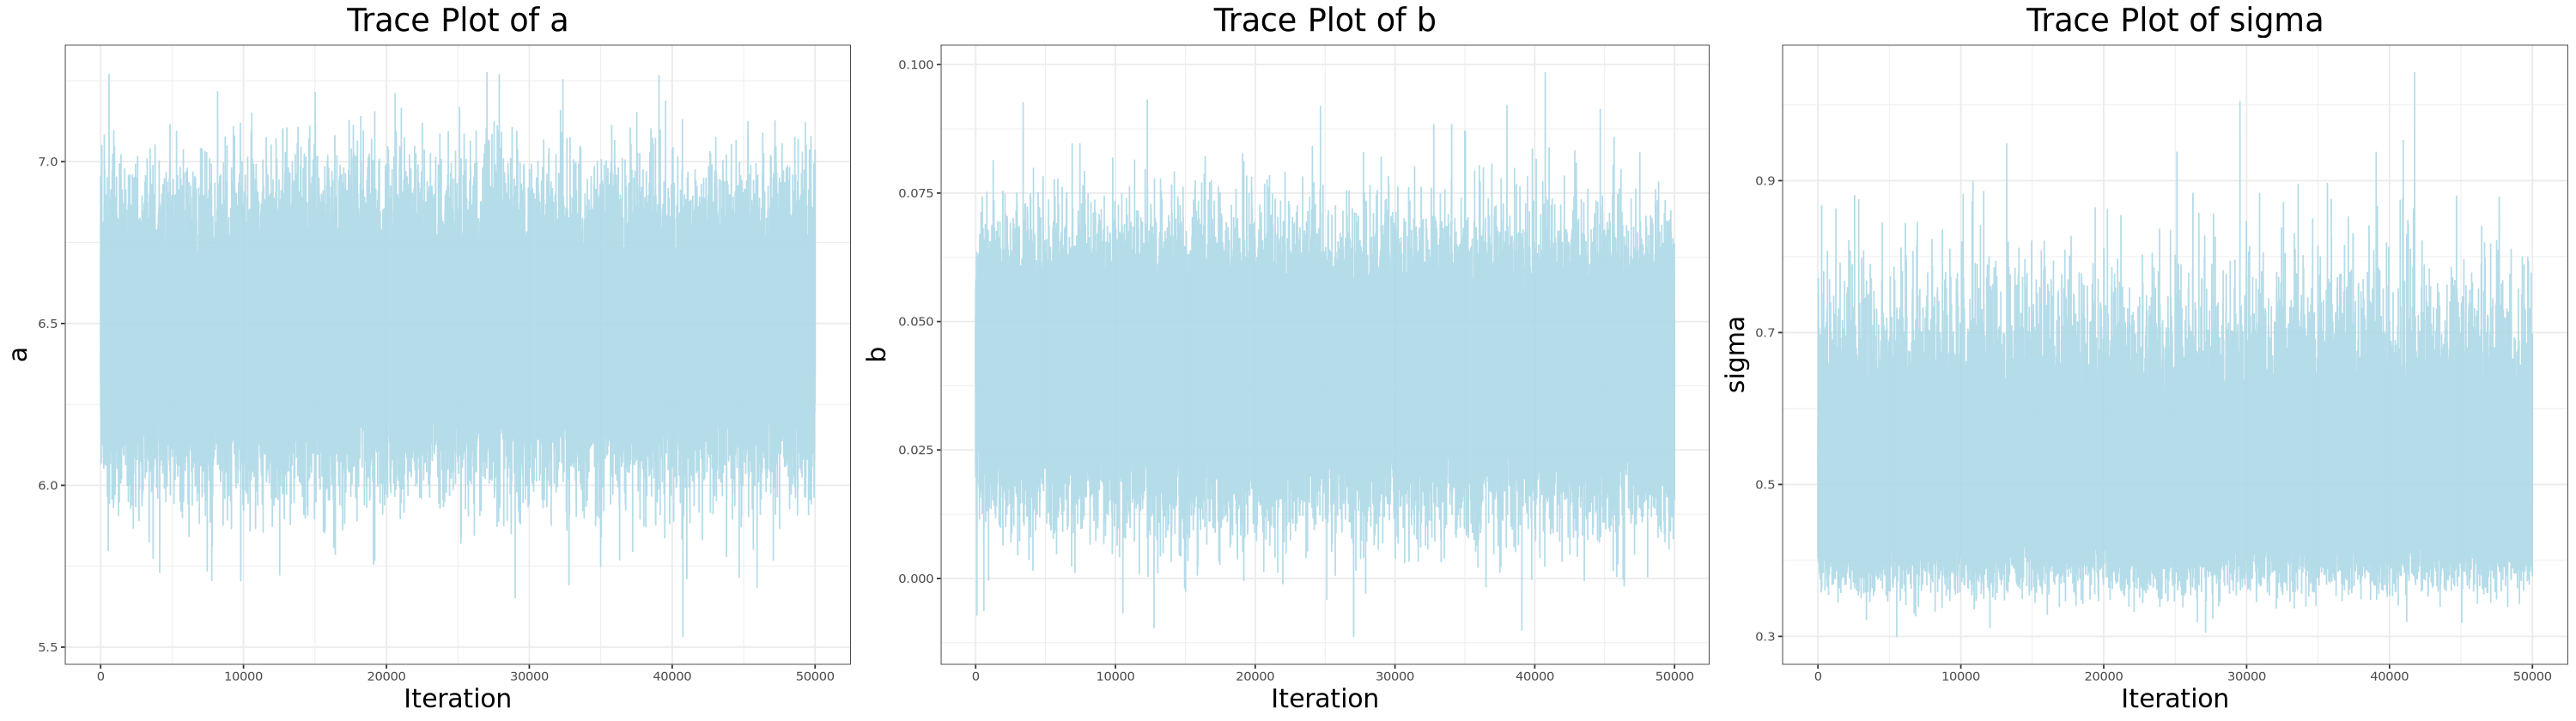

In [75]:
density_plot(lin_chain, 'linear', 'min')
trace_plot(lin_chain, 'linear', 'min')


Test's statistic (D): 9.001158 
Degrees of freedom (df): 1 
p-value: 0.002698087 


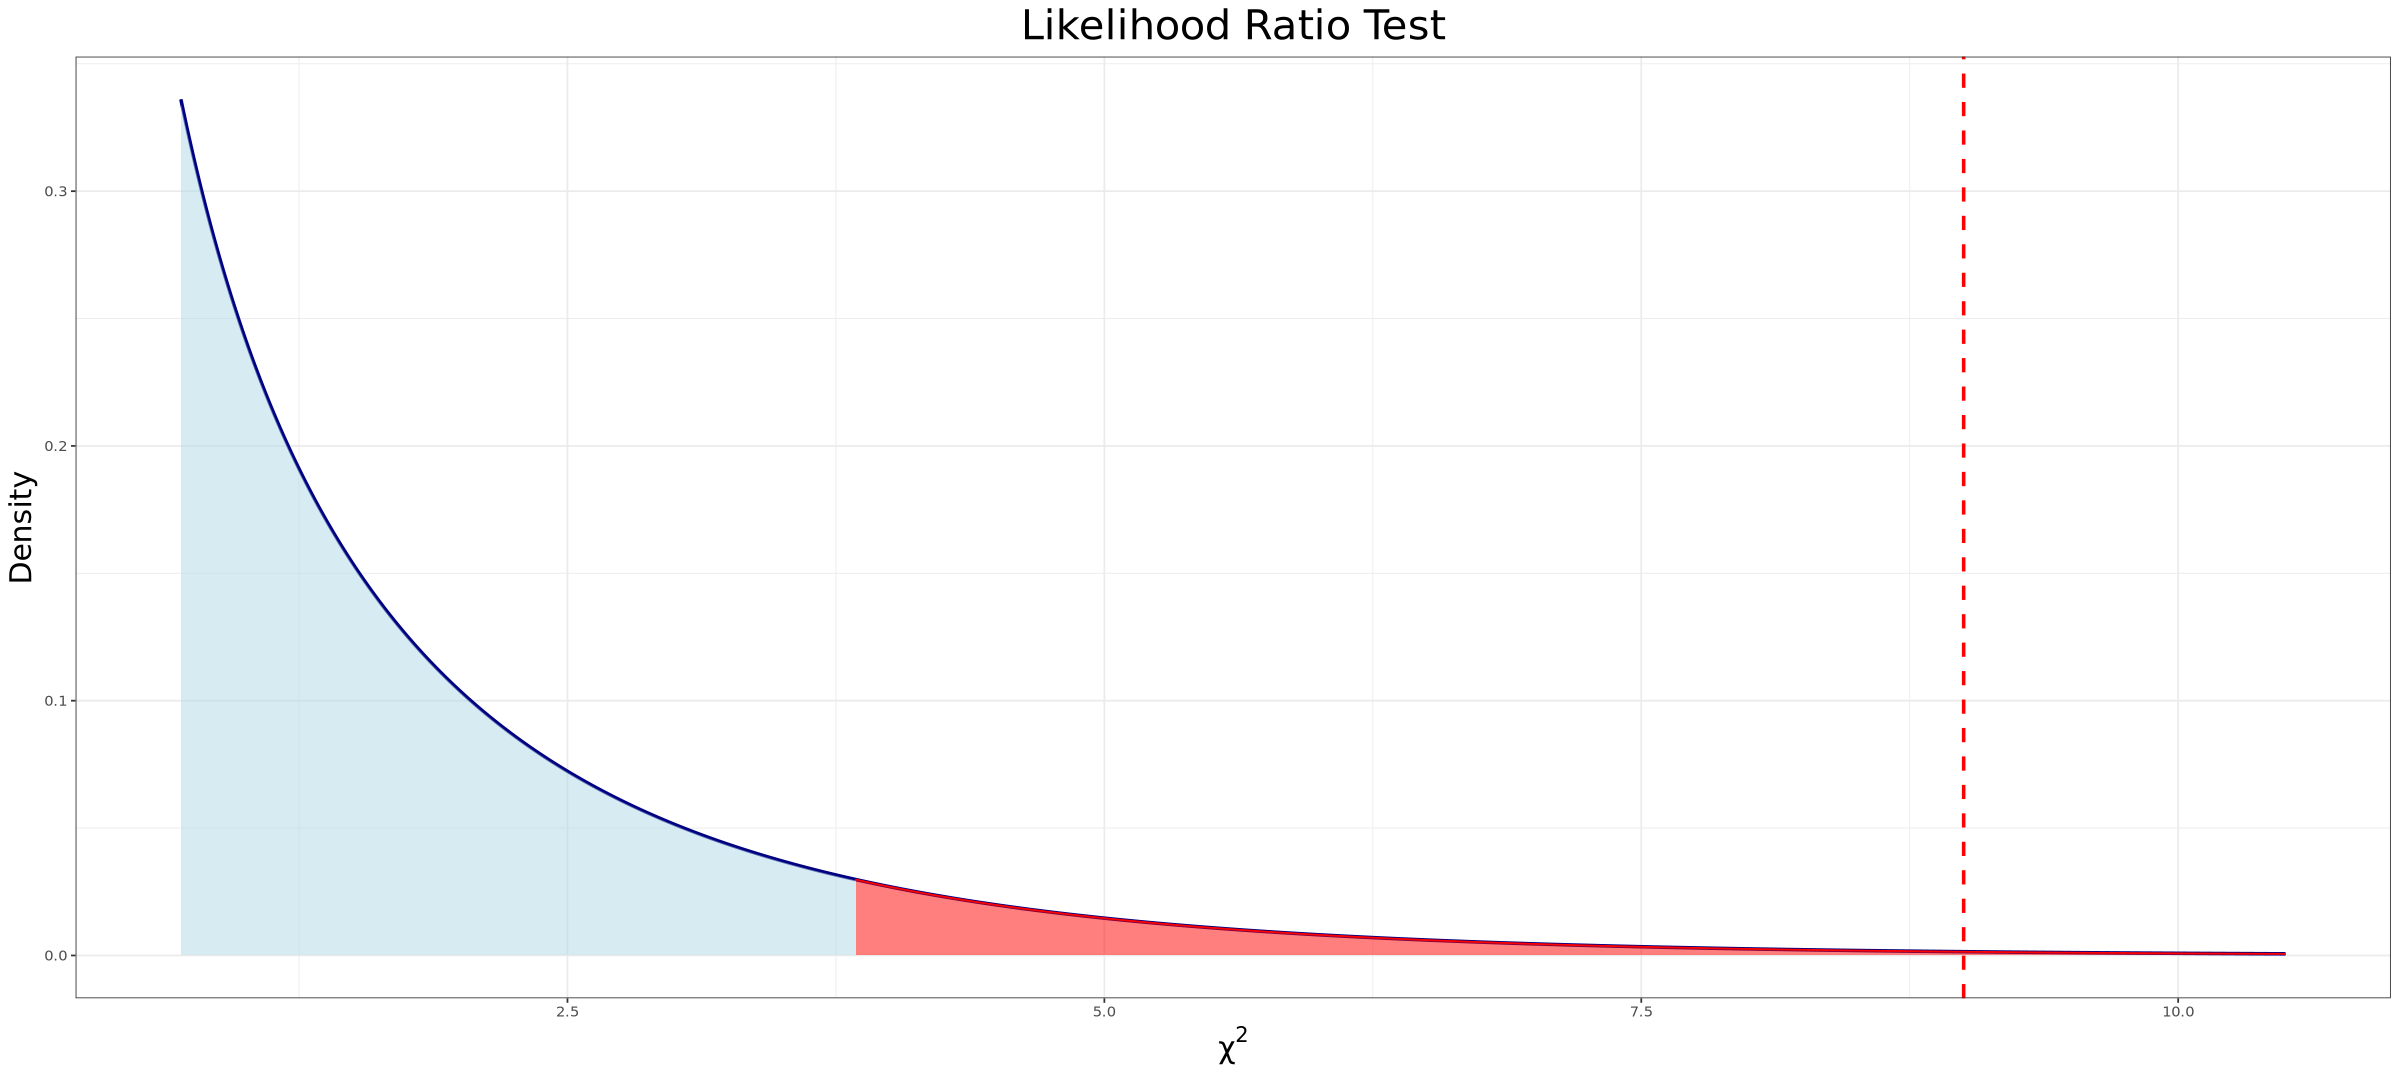

In [76]:
linear_likelihood <- get_model_likelihood(lin_chain, yearly_dataset, type = 'linear',temp = 'ava')
constant_likelihood <- get_model_likelihood(const_chain, yearly_dataset, type = 'constant', temp = 'ava')
#print(linear_likelihood )
#print(constant_likelihood )


log_likelihood_ratio <-   2 * ( linear_likelihood - constant_likelihood)
degree_freedom <- 1
p_value <- pchisq(log_likelihood_ratio, df = degree_freedom, lower.tail = FALSE)



cat("Test's statistic (D):", log_likelihood_ratio, "\n")
cat("Degrees of freedom (df):", degree_freedom, "\n")
cat("p-value:", p_value, "\n")


x <- seq(0.7, 10.5, length.out = 10000)
y <- dchisq(x, degree_freedom)
chi_95 <- qchisq(0.95, df = degree_freedom)

data <- data.frame(x = x, y = y)
options(repr.plot.width = 20, repr.plot.height = 9)

p<-ggplot(data, aes(x = x, y = y)) +
  geom_line(color = "navy", size = 1) +
  geom_vline(xintercept = log_likelihood_ratio, color = "red", linetype = 2, size = 1) +
  geom_area(data = subset(data, x >= chi_95), aes(x = x, y = y), fill = "red", alpha = 0.5, color = 'red') +
  geom_area(data = subset(data, x <= chi_95), aes(x = x, y = y), fill = "lightblue", alpha = 0.5, color = 'navy') +
  labs(title = "Likelihood Ratio Test",
       x = expression(chi^2),
       y = "Density")+
  theme_bw() +
  theme(plot.title = element_text(size = 25, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
p

- We now look for correlations between the temperature measured in stations.

`summarise()` has grouped output by 'year_only'. You can override using the `.groups` argument.


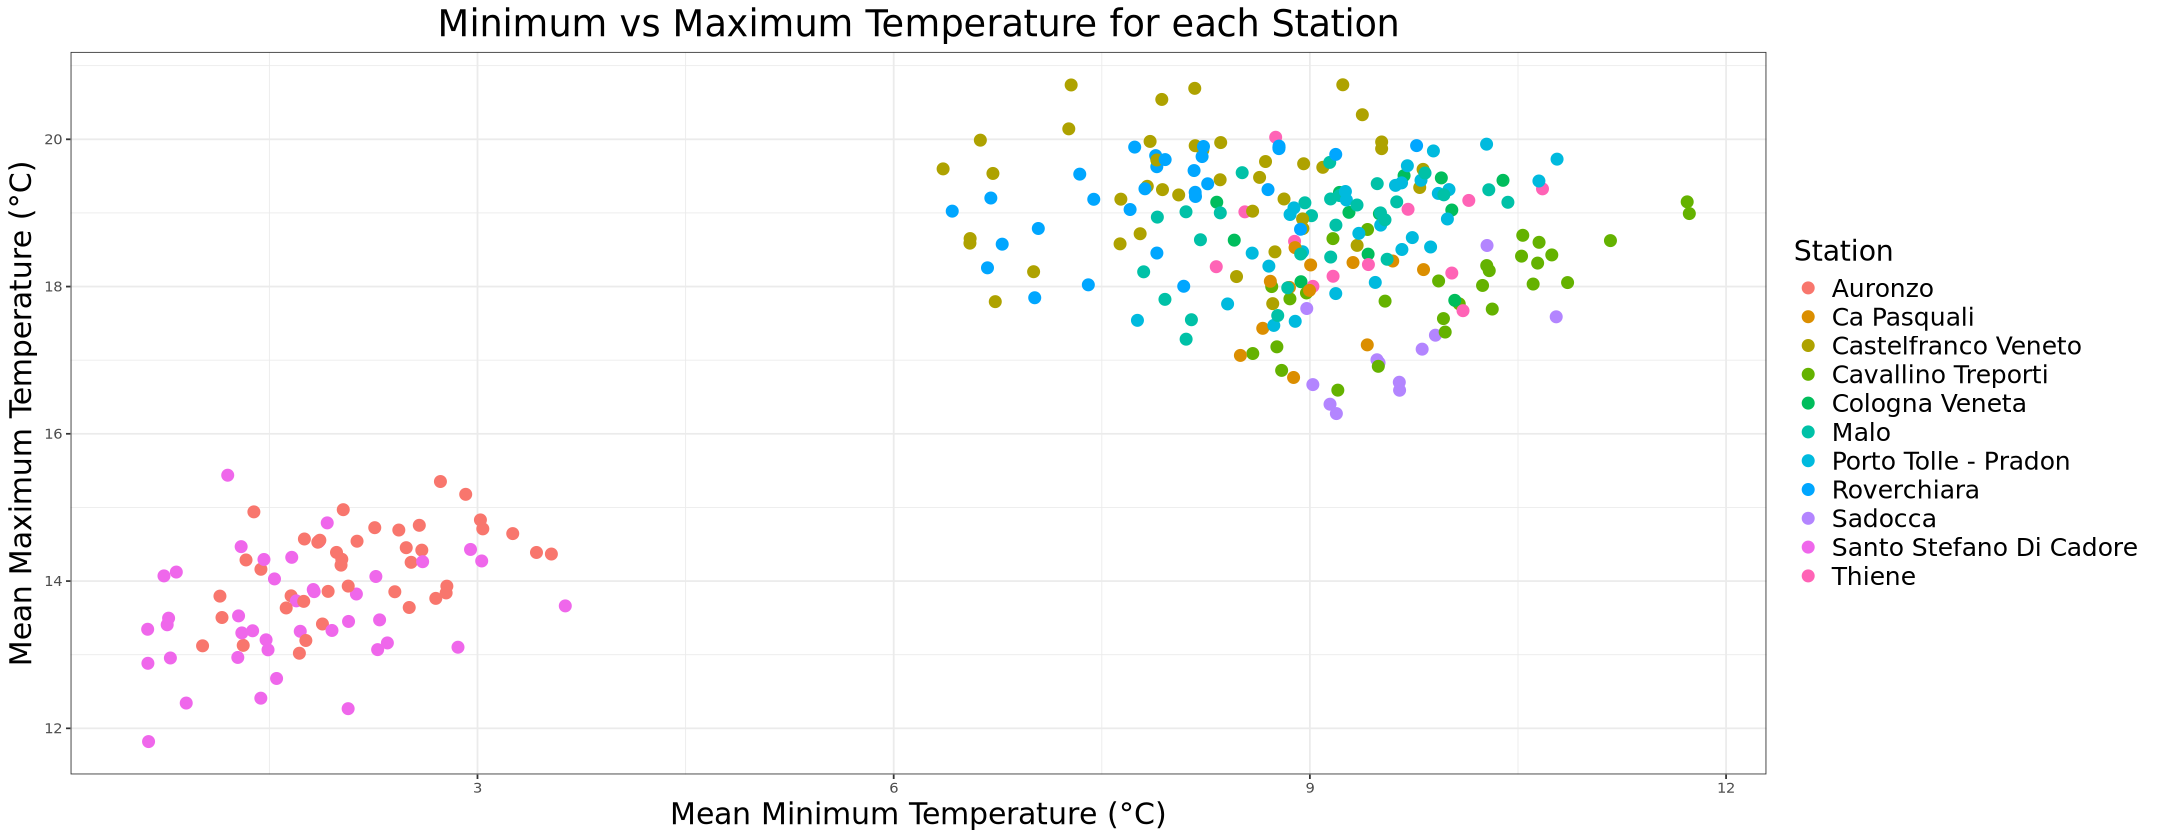

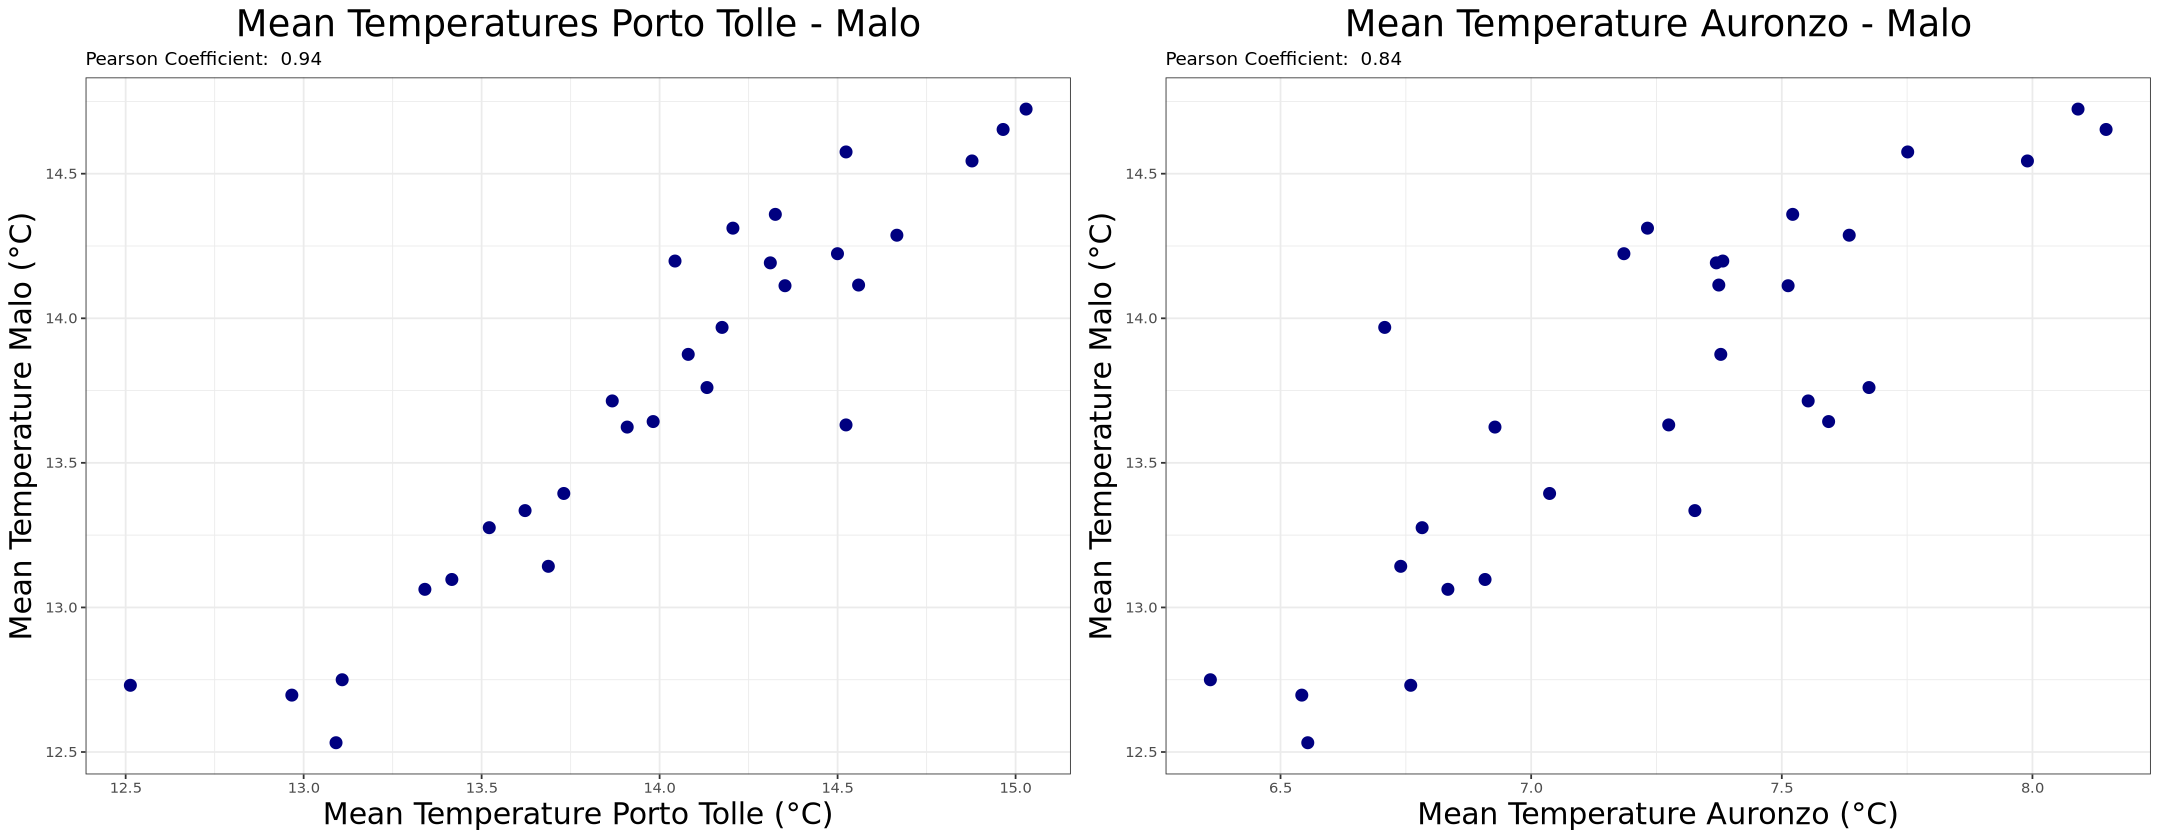

In [77]:

city_dataset <- daily_dataset |>
  group_by(year_only, file) |>
  summarise(MIN_mean = mean(TMIN, na.rm = TRUE),
            MED_mean = mean(TMED, na.rm = TRUE),
            MAX_mean = mean(TMAX, na.rm = TRUE))


porto_tolle <- city_dataset |> filter(file == 'Porto Tolle - Pradon')
malo <- city_dataset |> filter(file == 'Malo')
auronzo <- city_dataset |> filter(file == 'Auronzo')
city_dataset['file'][[1]]<-str_to_title(city_dataset['file'][[1]])
city_dataset['file'][[1]]<-str_replace(city_dataset['file'][[1]],"S. ","Santo ")

corr_df1 <- data.frame(porto_tolle, malo)
corr_df2 <- data.frame(auronzo, malo)

# Opzioni per la dimensione del plot
options(repr.plot.width = 18, repr.plot.height = 7)


ggplot(city_dataset, aes(x = MIN_mean, y = MAX_mean, color = file)) +
  geom_point(size = 3) +
  labs(
    title = "Minimum vs Maximum Temperature for each Station",
    x = "Mean Minimum Temperature (°C)",
    y = "Mean Maximum Temperature (°C)",
    color = "Station"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


correlation_pearson <- cor(porto_tolle$MED_mean, malo$MED_mean, method = "pearson")
conf1<-ggplot(corr_df1, aes(x = MED_mean, y = MED_mean.1)) +
  geom_point(size = 3, color = 'navy') +
  labs(
    title = "Mean Temperatures Porto Tolle - Malo",
    subtitle = paste("Pearson Coefficient: ", round(correlation_pearson, 2)),
    x = "Mean Temperature Porto Tolle (°C)",
    y = "Mean Temperature Malo (°C)"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5,color=),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

correlation_pearson <- cor(auronzo$MED_mean, malo$MED_mean, method = "pearson")
conf2<-ggplot(corr_df2, aes(x = MED_mean, y = MED_mean.1)) +
  geom_point(size = 3, color = 'navy') +
  labs(
    title = "Mean Temperature Auronzo - Malo",
    subtitle = paste("Pearson Coefficient: ", round(correlation_pearson, 2)),
    x = "Mean Temperature Auronzo (°C)",
    y = "Mean Temperature Malo (°C)"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

grid.arrange(conf1,conf2, 
             ncol = 2, nrow = 1)

The first plot clearly tells us that the mountains temperatures cluster in a different area with respect to all the other, as is expected.
If we try to compare the mean temperatures between a station in a mountain area and one slightly below we get a poorer Pearson correlation coefficient than doing the same between the same medium altitude station and a low altitude one. It is also evident by how spread the two plots are around the diagonal, with the lower coefficient one being wider.

## **Annual Difference Evolution Analysis**

We now analyze the evolution of the annual difference in temperature, determining each difference as the one between the current and the average over the ones in the past 4 years.

year_only,MIN_mean,MED_mean,MAX_mean,x_fit
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1993,6.279188,11.29433,16.70935,1
1997,6.528919,11.82113,17.52378,2
2001,6.674016,11.79522,17.37981,3
2005,6.042278,10.82510,16.27128,4
2009,7.212099,12.08863,17.65046,5
2013,7.549836,11.98275,17.08315,6
2017,6.933232,11.98327,17.81874,7
2021,6.750020,11.72077,17.39425,8


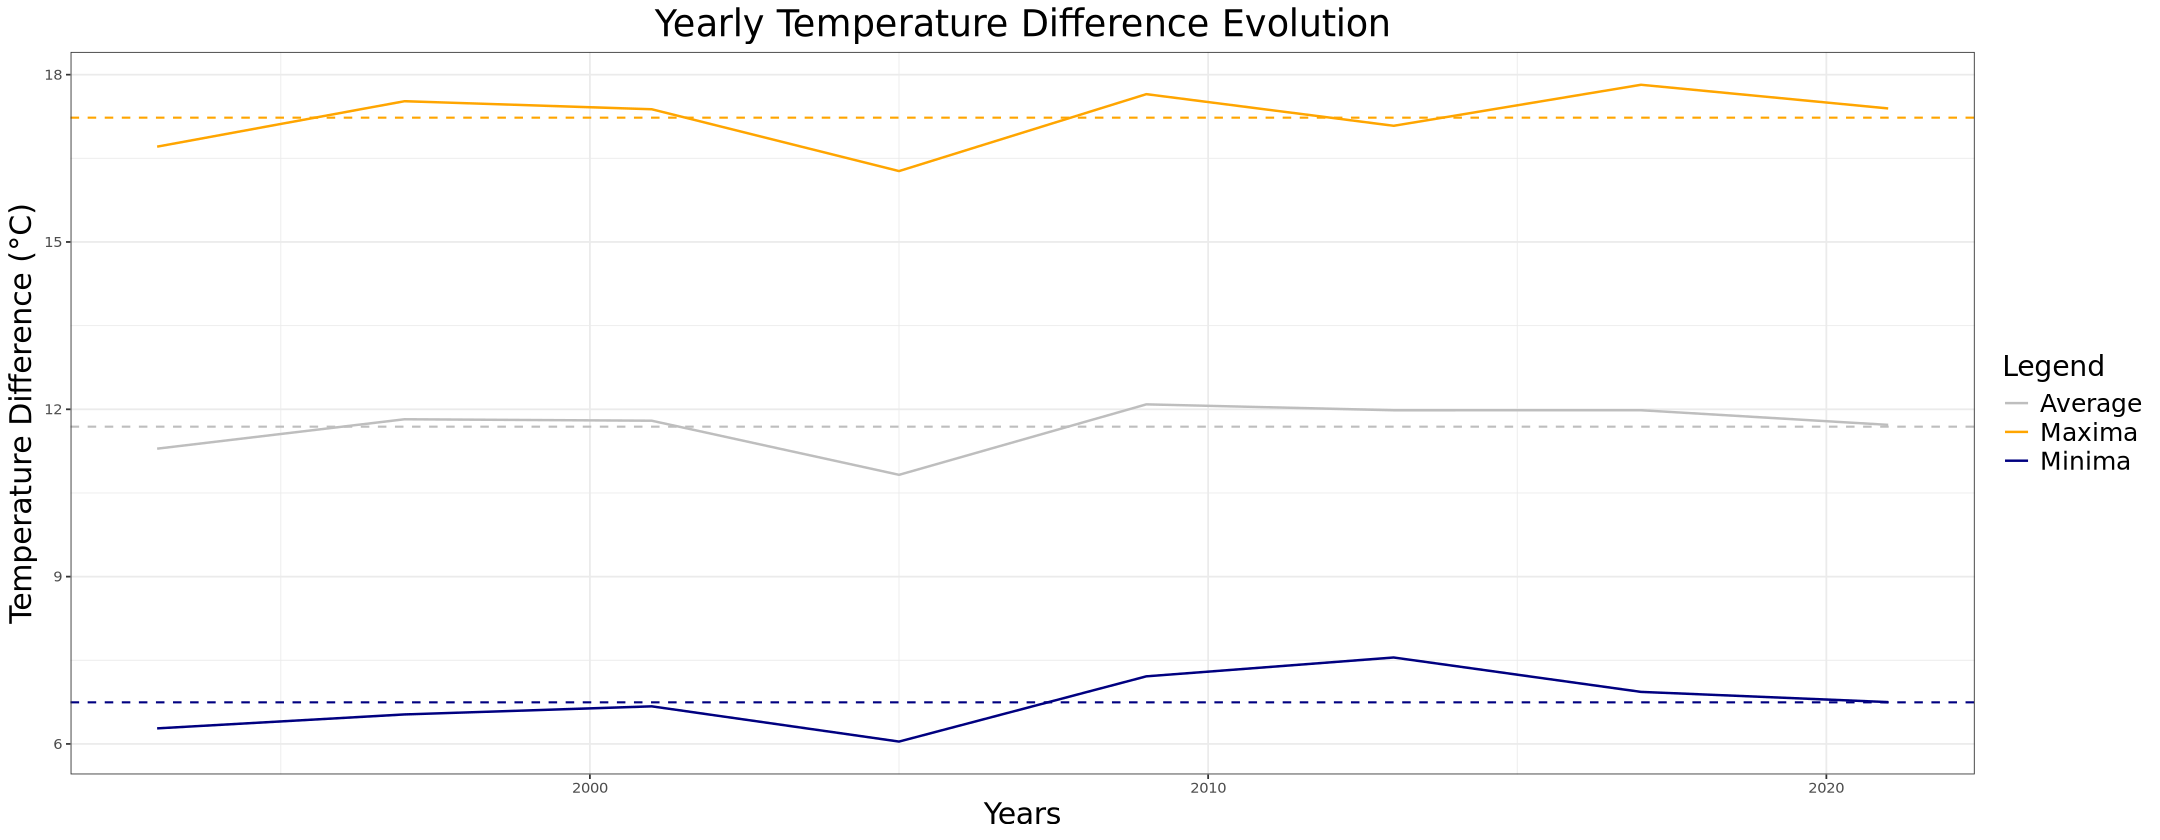

In [78]:
filtered <- yearly_dataset %>%
  filter((year_only - min(year_only))%% 4 == 0) |> mutate(x_fit = 1:length(year_only))

# Visualizziamo il dataframe filtrato
(filtered)

options(repr.plot.width = 18, repr.plot.height = 7)
p_y <- ggplot(data = filtered) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Difference Evolution',
       x = 'Years',
       y = 'Temperature Difference (°C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
p_y


We now fit the temperature difference trends with a linear model using *rjags* as before.

In [79]:
lin_chain <- regression(filtered, lin_model_file, lin_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 9
   Total graph size: 102

Initializing model



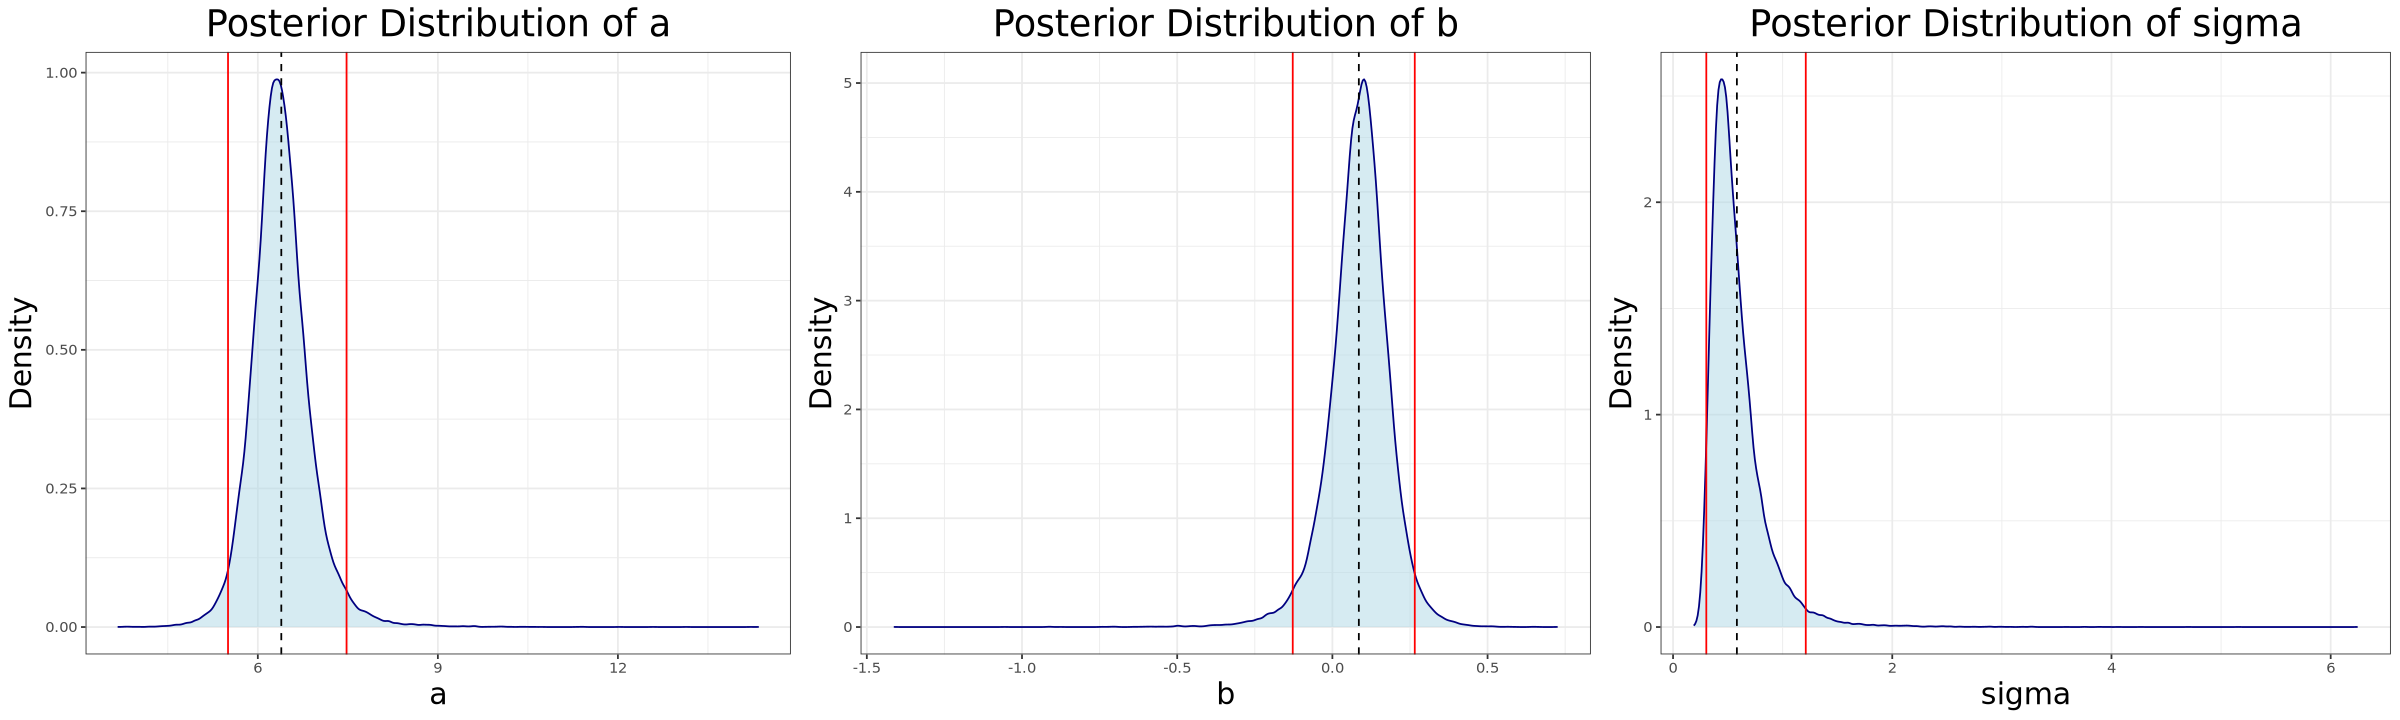

In [81]:
density_plot(lin_chain, 'linear', 'min')

## **Comparing SNPA to our regression**
http://www.math.nagoya-u.ac.jp/~richard/teaching/s2021/SML_Guozhang6.pdf



We want now to compare the values we infer from the montecarlo process with the one obtained in the SNPA document so our hypotesis test is set as:


$\left\{\begin{array}{rl}
H_0 : b' \in [\mu_{snpa} - k, \mu_{snpa} + k]\\
H_0 : b' \not\in [\mu_{snpa} - k, \mu_{snpa} + k]
\end{array}
\right.$

with $k$ half of the confidential interval. If now we rescale the distribution of b we can obtain $b' \sim N(\mu', \sigma') : \mu' = \frac{10}{4}\mu_b , \sigma' = \frac{10}{4}\sigma_b$ so now 

$P(H_0 | \mu_{snpa}, k, b') = P(b' \in [\mu_{snpa} - k, \mu_{snpa} + k]) = \int_{\mu_{snpa} - k}^{\mu_{snpa} + k} p(b') db'$

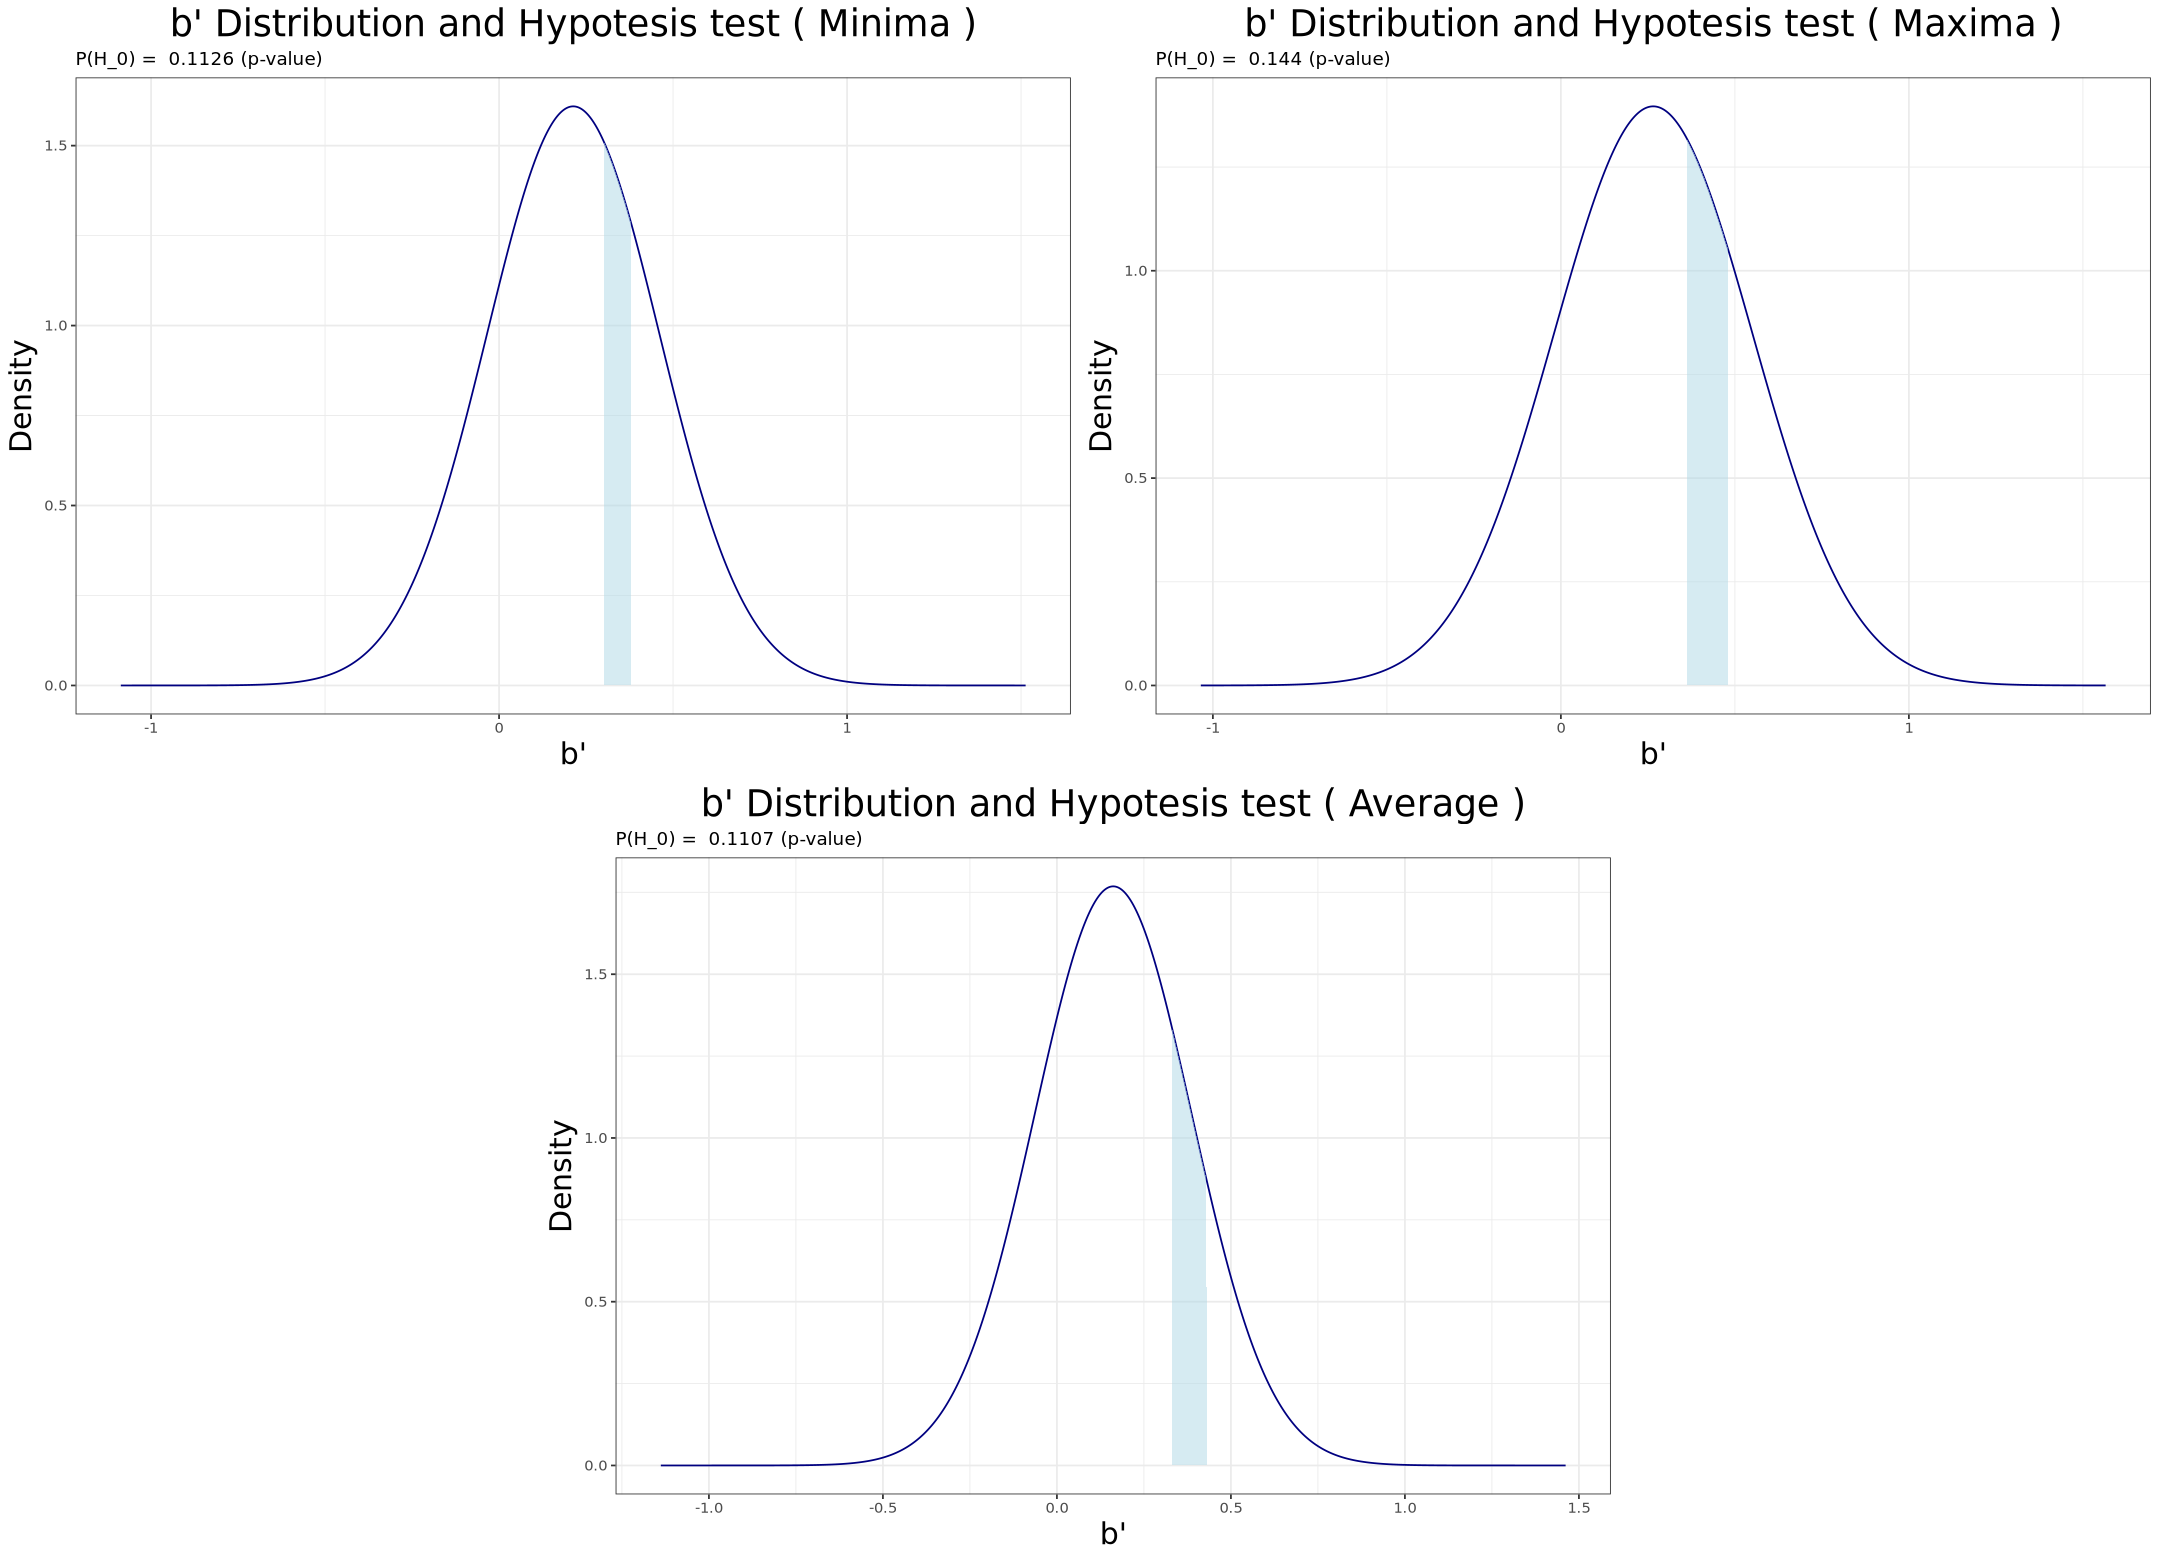

In [82]:
snpa_htest <- function(chain, temp){

    if(temp == 'max'){
        snpa <- list( mu = 0.42, k = 0.06 )
        str<-'Maxima'
    }
    if(temp == 'ava'){
        snpa <- list( mu = 0.38, k = 0.05 )
        str<-'Average'
    }
    if(temp == 'min'){
        snpa <- list( mu = 0.34, k = 0.04 )
        str<-'Minima'
    }

    b_prime_param <- get_model_parameters(chain ,type = 'linear',temp)
    b_prime_mu <- 2.5*b_prime_param[['b']]
    b_prime_sd <- 2.5*b_prime_param[['sd_b']]

    x = seq(b_prime_mu-1.3,b_prime_mu+1.3,0.002)
    b_prime_post <- dnorm(x, b_prime_mu, b_prime_sd)
    test_area <- integrate(dnorm, lower = snpa[['mu']]-snpa[['k']], upper = snpa[['mu']]+snpa[['k']], mean = b_prime_mu, sd = b_prime_sd)$value


    df <- data.frame(x = x, y = b_prime_post)
    options(repr.plot.width = 8, repr.plot.height = 7)
    plot <- ggplot(df, aes(x = x, y = y)) +
        geom_line(color = 'navy') +
        geom_area(data = subset(df, x >= snpa[['mu']]-snpa[['k']] & x <= snpa[['mu']]+snpa[['k']]), aes(x = x, y = y), fill = 'lightblue', alpha = 0.5) +
        labs(title = paste("b' Distribution and Hypotesis test (",str,")"),
             subtitle = paste("P(H_0) = ", round(test_area, 4),'(p-value)'),
             x = "b'",
             y = "Density") +
        theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
    
    chaindf <- as.data.frame( as.mcmc(chain))[['b_min']]
    filtered_b_ava <- chaindf[2*chaindf >= (snpa[['mu']] - snpa[['k']])]
    filtered_b_ava <- filtered_b_ava[2*filtered_b_ava <= (snpa[['mu']] + snpa[['k']])]

    return (plot)
}


p_min<-snpa_htest(lin_chain, temp = 'min')
p_ava<-snpa_htest(lin_chain, temp = 'ava')
p_max<-snpa_htest(lin_chain, temp = 'max')
options(repr.plot.width = 18, repr.plot.height = 13)
grid.arrange(p_min, p_max, p_ava, ncol = 2, nrow = 2, layout_matrix=rbind(c(1,1, 2,2), c(NA, 3, 3, NA)))

All the p-values are well above the acceptance value of *0.05* hence we accept the null hypothesis, namely that our data predictions fall within the SNPA credibility interval, with a 95 % confidence level.

## ***Forecast* Time Series Analysis**

As a last way to analyze our dataset and to also predict the future trends in temperatures we make use of a dedicated package for time series analysis: *forecast*. This helps us fitting several models to the time serie, in particular *ARIMA* (AutoRegressive Integrate Moving Average):

$y'_t=c+\alpha_1y'_{t-1}+\alpha_2y'_{t-2}+\dots+\alpha_py'_{t-p}+\epsilon_t+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+\dots+\theta_q\epsilon_{t-q}$

where $y'_t=y_t-y_{t-1}$ is the differed time serie to correct eventual non stationarities of the mean.

In [83]:
plot_forecast <- function(timeseries, forecast, test = TRUE) {
  lower <- forecast[[5]][,1]
  upper <- forecast[[6]][,1]
  
  forecast <- forecast[[4]]
  n_forecast <- length(forecast)
  n_series <- length(timeseries)
  
  # Calcolare gli anni
  years <- 1993:(1993 + n_series + n_forecast - 1)
  
  if (test) {
    series <- timeseries
    forecast_x <- (n_series - n_forecast + 1):n_series
    df_forecast <- data.frame(x = forecast_x, series = forecast, l_ribbon = lower, u_ribbon = upper)
  } else {
    upper <- c(rep(NA, n_series), upper) 
    lower <- c(rep(NA, n_series), lower)  
    series <- c(timeseries, forecast)
    df_forecast <- data.frame(x = (n_series + 1):(n_series + n_forecast), series = forecast, l_ribbon = lower[(n_series + 1):(n_series + n_forecast)], u_ribbon = upper[(n_series + 1):(n_series + n_forecast)])
  }
  
  x <- 1:length(series)
  df <- data.frame(x = x, series = series)
  
  # Creare il grafico
  p <- ggplot(df) +
    geom_line(aes(x = x, y = series), color = 'navy', size = 1) +
    geom_line(data = df_forecast, aes(x = x, y = series), color = 'red', size = 1) +
    geom_ribbon(data = df_forecast, aes(x = x, ymin = l_ribbon, ymax = u_ribbon), color = 'red', size = 1, alpha = 0.2, fill = 'lightblue') +
    scale_x_continuous(breaks = 1:length(years), labels = years) +
    theme_bw()
  
  print(p)
}

plot_forecast_non_stationary <- function(timeseries, forecast, test = TRUE) {
  # Rendere non stazionari i dati
  non_stationary_timeseries <- timeseries
  non_stationary_forecast <- cumsum(forecast[[4]]) + timeseries[length(timeseries)]
  
  lower <- non_stationary_forecast - (forecast[[5]][,1]) 
  upper <- non_stationary_forecast + (forecast[[6]][,1]) 
  
  forecast <- non_stationary_forecast
  n_forecast <- length(forecast)
  n_series <- length(non_stationary_timeseries)
  
  # Calcolare gli anni
  years <- 1993:(1993 + n_series + n_forecast - 1)
  
  if (test) {
    series <- non_stationary_timeseries
    forecast_x <- (n_series - n_forecast + 1):n_series
    df_forecast <- data.frame(x = forecast_x , series = forecast, l_ribbon = lower, u_ribbon = upper)
  } else {
    upper <- c(rep(NA, n_series), upper) 
    lower <- c(rep(NA, n_series), lower)  
    series <- c(non_stationary_timeseries, forecast)
    df_forecast <- data.frame(x = (n_series + 1):(n_series + n_forecast) , series = forecast, l_ribbon = lower[(n_series + 1):(n_series + n_forecast)], u_ribbon = upper[(n_series + 1):(n_series + n_forecast)])
  }
  
  x <- 1:length(series)
  df <- data.frame(x = x, series = series)
  
  # Creare il grafico
  p <- ggplot(df) +
    geom_line(aes(x = x, y = series), color = 'navy', size = 1) +
    geom_line(data = df_forecast, aes(x = x, y = series), color = 'red', size = 1) +
    #geom_ribbon(data = df_forecast, aes(x = x, ymin = l_ribbon, ymax = u_ribbon), color = 'red', size = 1, alpha = 0.2, fill = 'lightblue') +
    scale_x_continuous(breaks = 1:length(years), labels = years) +
    theme_bw()
  
  print(p)

}

find_best_arima_model <- function(timeseries, iterations) {
    # Divide the series into training and test sets
    n_train <- floor(0.8 * length(timeseries))
    training_set <- timeseries[1:n_train] 
    test_set <- timeseries[(n_train + 1):length(timeseries)]  

    # Initialize variables to store the best model
    best_model <- NULL
    best_rmse <- Inf 
    best_aic <- Inf  
    best_params <- NULL
    
    set.seed(123)
    
    # Iterate to find the best ARIMA model
    for (i in 1:iterations) {
        p <- sample(1:4, 1)
        d <- sample(1:4, 1)
        q <- sample(1:4, 1)
        
        model <- Arima(training_set, order = c(p, d, q),include.mean = TRUE)
        forecasts <- forecast(model, h = length(test_set))
        
        # Calculate RMSE
        #rmse <- sqrt(mean((forecasts$mean - test_set)^2))
        aic <- AIC(model)

        # Update best model if current model is better
        if (aic < best_aic){
            best_model <- model
            #best_rmse <- rmse
            best_aic <- aic
            best_params <- c(p, d, q)
        }
    }
    
    # Train the best model on the entire dataset
    final_model <- Arima(timeseries, order = best_params)

    print(summary(final_model))
    plot_forecast(timeseries, forecast = forecasts, test = TRUE)
    
    return(list(best_model = final_model, training = training_set, test = test_set, best_params = best_params))
}
find_best_sarima_model <- function(timeseries, iterations, seasonal_period = 12) {
    # Divide the series into training and test sets
    n_train <- floor(0.8 * length(timeseries))
    training_set <- timeseries[1:n_train]
    test_set <- timeseries[(n_train + 1):length(timeseries)]  

    # Initialize variables to store the best model
    best_model <- NULL
    best_rmse <- Inf 
    best_aic <- Inf  
    best_params <- NULL
    
    set.seed(123)
    
    # Iterate to find the best SARIMA model
    for (i in 1:iterations) {
        p <- sample(0:4, 1)  # Non-seasonal AR order
        d <- sample(0:2, 1)  # Non-seasonal differencing order
        q <- sample(0:4, 1)  # Non-seasonal MA order
        P <- sample(0:2, 1)  # Seasonal AR order
        D <- sample(0:1, 1)  # Seasonal differencing order
        Q <- sample(0:2, 1)  # Seasonal MA order
        
        # Fit SARIMA model
        model <- tryCatch({
            Arima(training_set, order = c(p, d, q), 
                  seasonal = list(order = c(P, D, Q), period = seasonal_period))
        }, error = function(e) { NULL })
        
        if (!is.null(model)) {
            forecasts <- forecast(model, h = length(test_set))
        
            # Calculate RMSE (commented out as it's not used for selection)
            # rmse <- sqrt(mean((forecasts$mean - test_set)^2))
            aic <- AIC(model)

            # Update best model if current model is better
            if (aic < best_aic) {
                best_model <- model
                # best_rmse <- rmse
                best_aic <- aic
                best_params <- list(p = p, d = d, q = q, P = P, D = D, Q = Q)
            }
        }
    }
    
    # Train the best model on the entire dataset
    final_model <- Arima(timeseries, order = c(best_params$p, best_params$d, best_params$q), 
                         seasonal = list(order = c(best_params$P, best_params$D, best_params$Q), period = seasonal_period),
                         include.mean = TRUE)

    print(summary(final_model))
    plot_forecast_non_stationary(timeseries, forecast = forecast(final_model, h = length(test_set)), test = TRUE)
    
    return(list(best_model = final_model, training = training_set, test = test_set, best_params = best_params))
}

Series: timeseries 
ARIMA(1,1,3) 

Coefficients:
          ar1      ma1      ma2     ma3
      -0.6389  -1.0339  -0.8894  0.9516
s.e.   0.2059   0.2543   0.3612  0.2483

sigma^2 = 0.2095:  log likelihood = -19.98
AIC=49.96   AICc=52.81   BIC=56.44

Training set error measures:
                      ME      RMSE      MAE      MPE     MAPE      MASE
Training set -0.02390879 0.4148421 0.290285 29.73437 76.18849 0.3765287
                      ACF1
Training set -0.0007199437


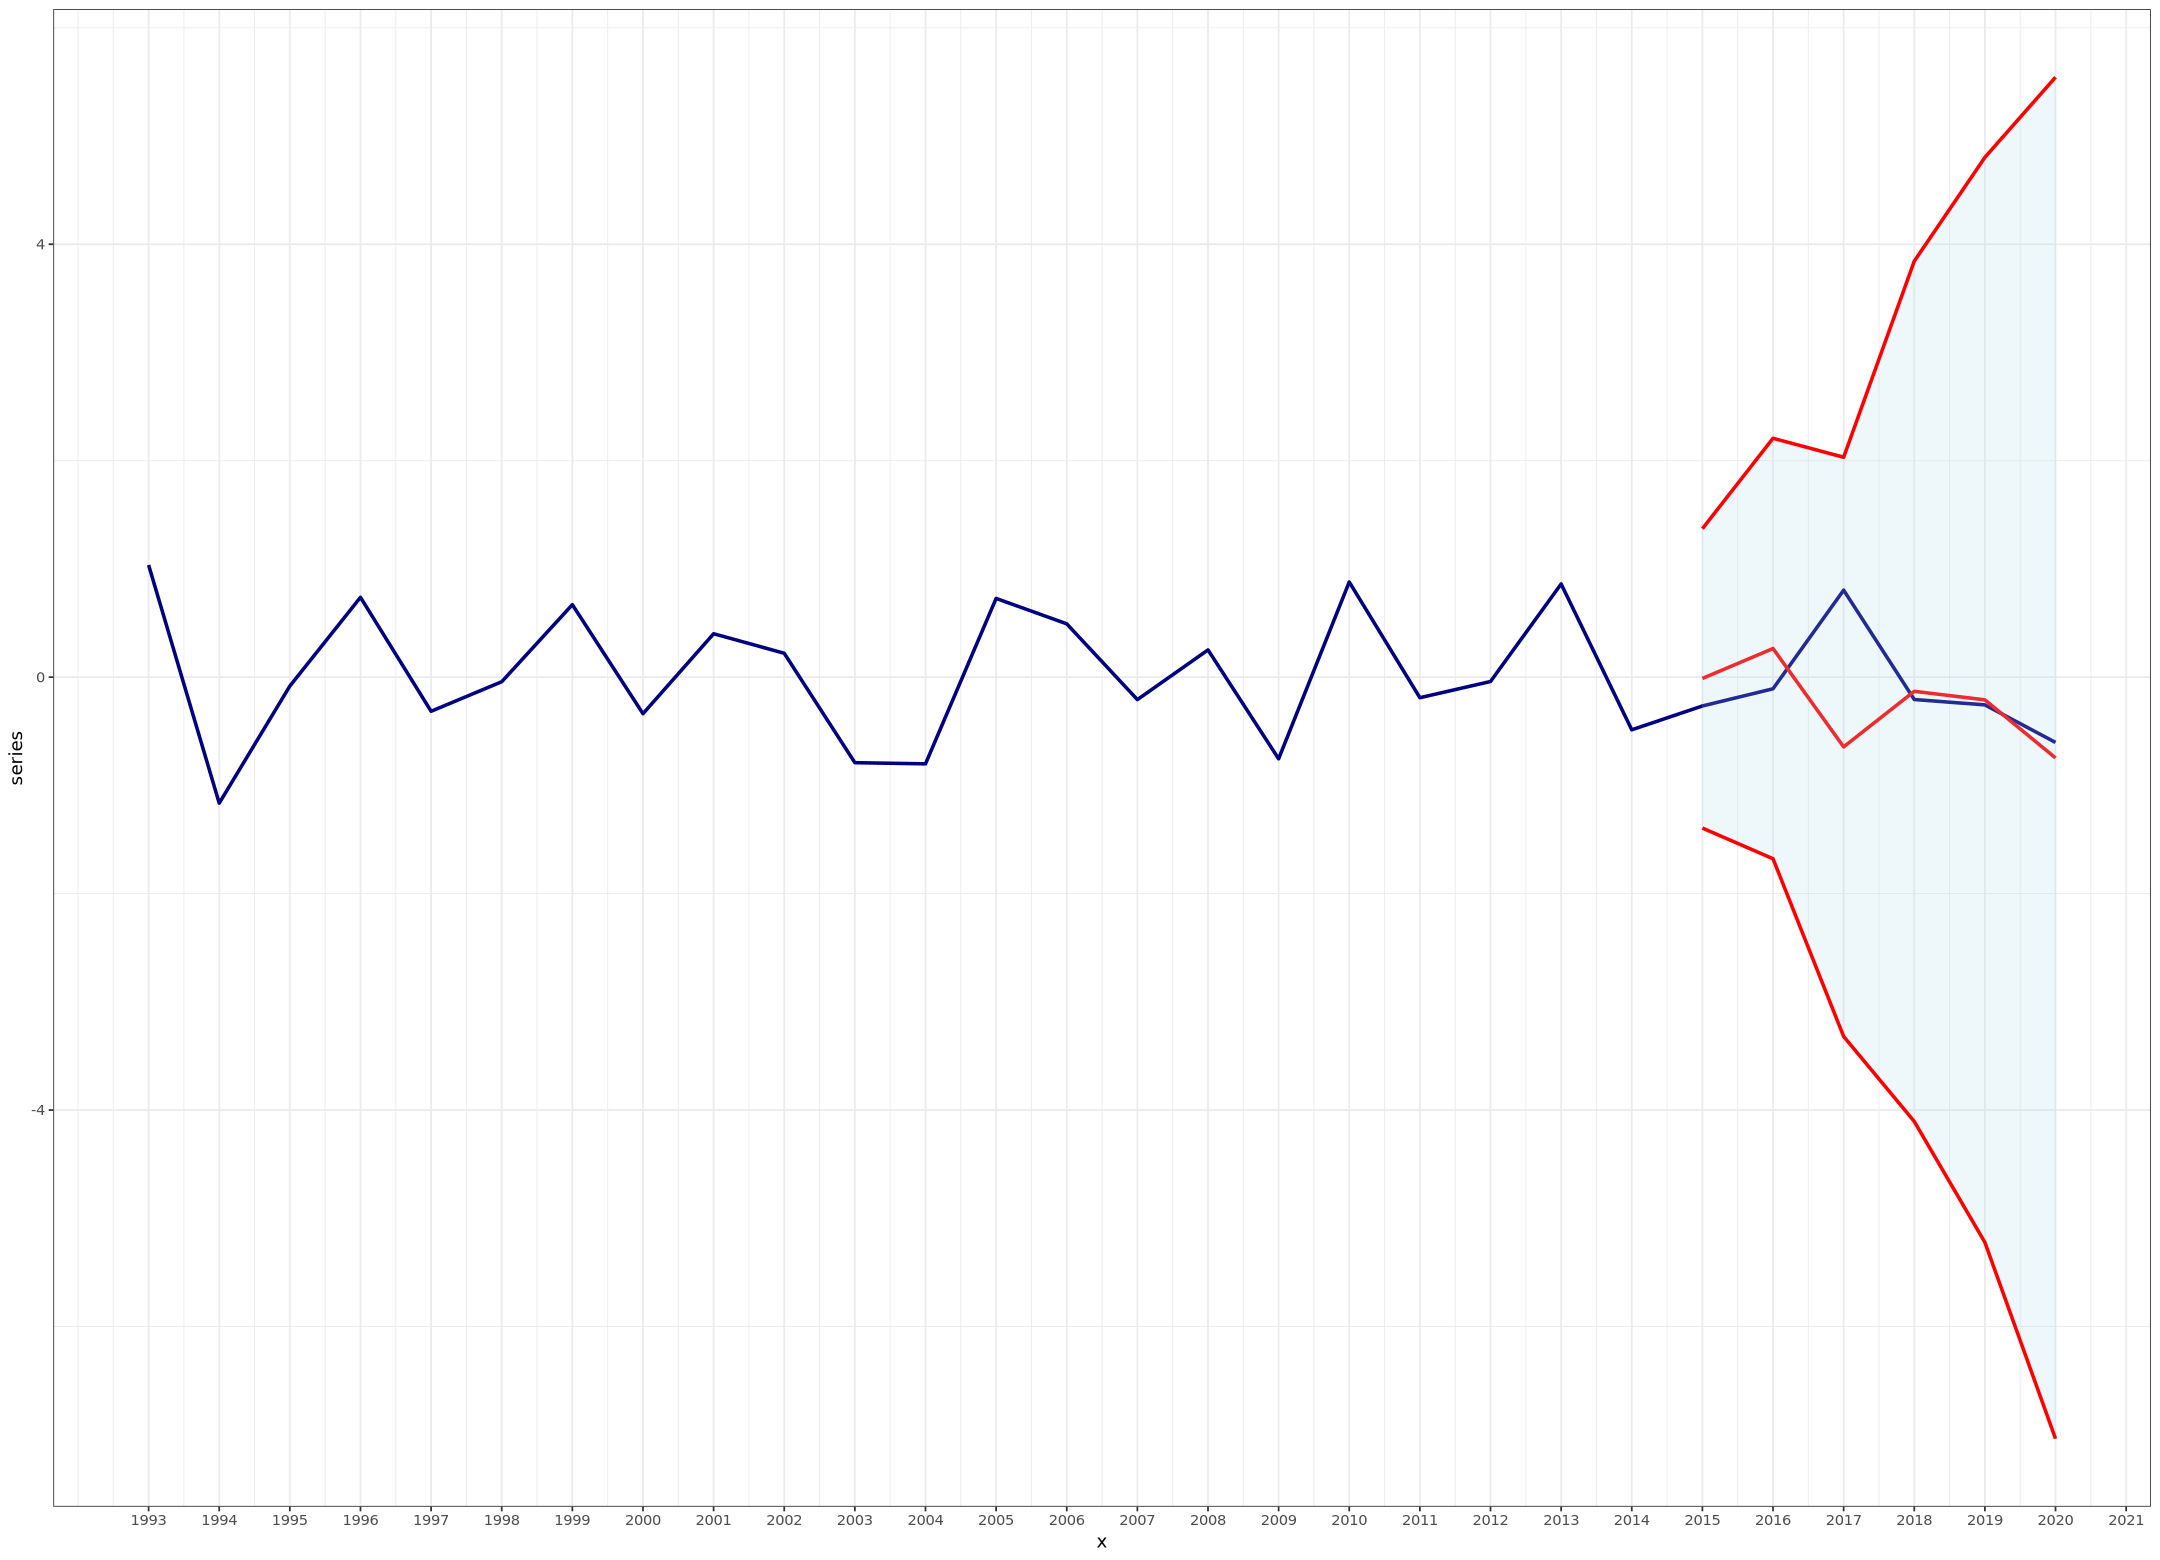

In [84]:
ts_data <- diff(yearly_dataset$MED_mean)
ts_monthly <- monthly_dataset$MED_mean
best_arima<-find_best_arima_model(timeseries = ts_data, iterations = 100)
prediction <- forecast(best_arima$best_model,h = 5)

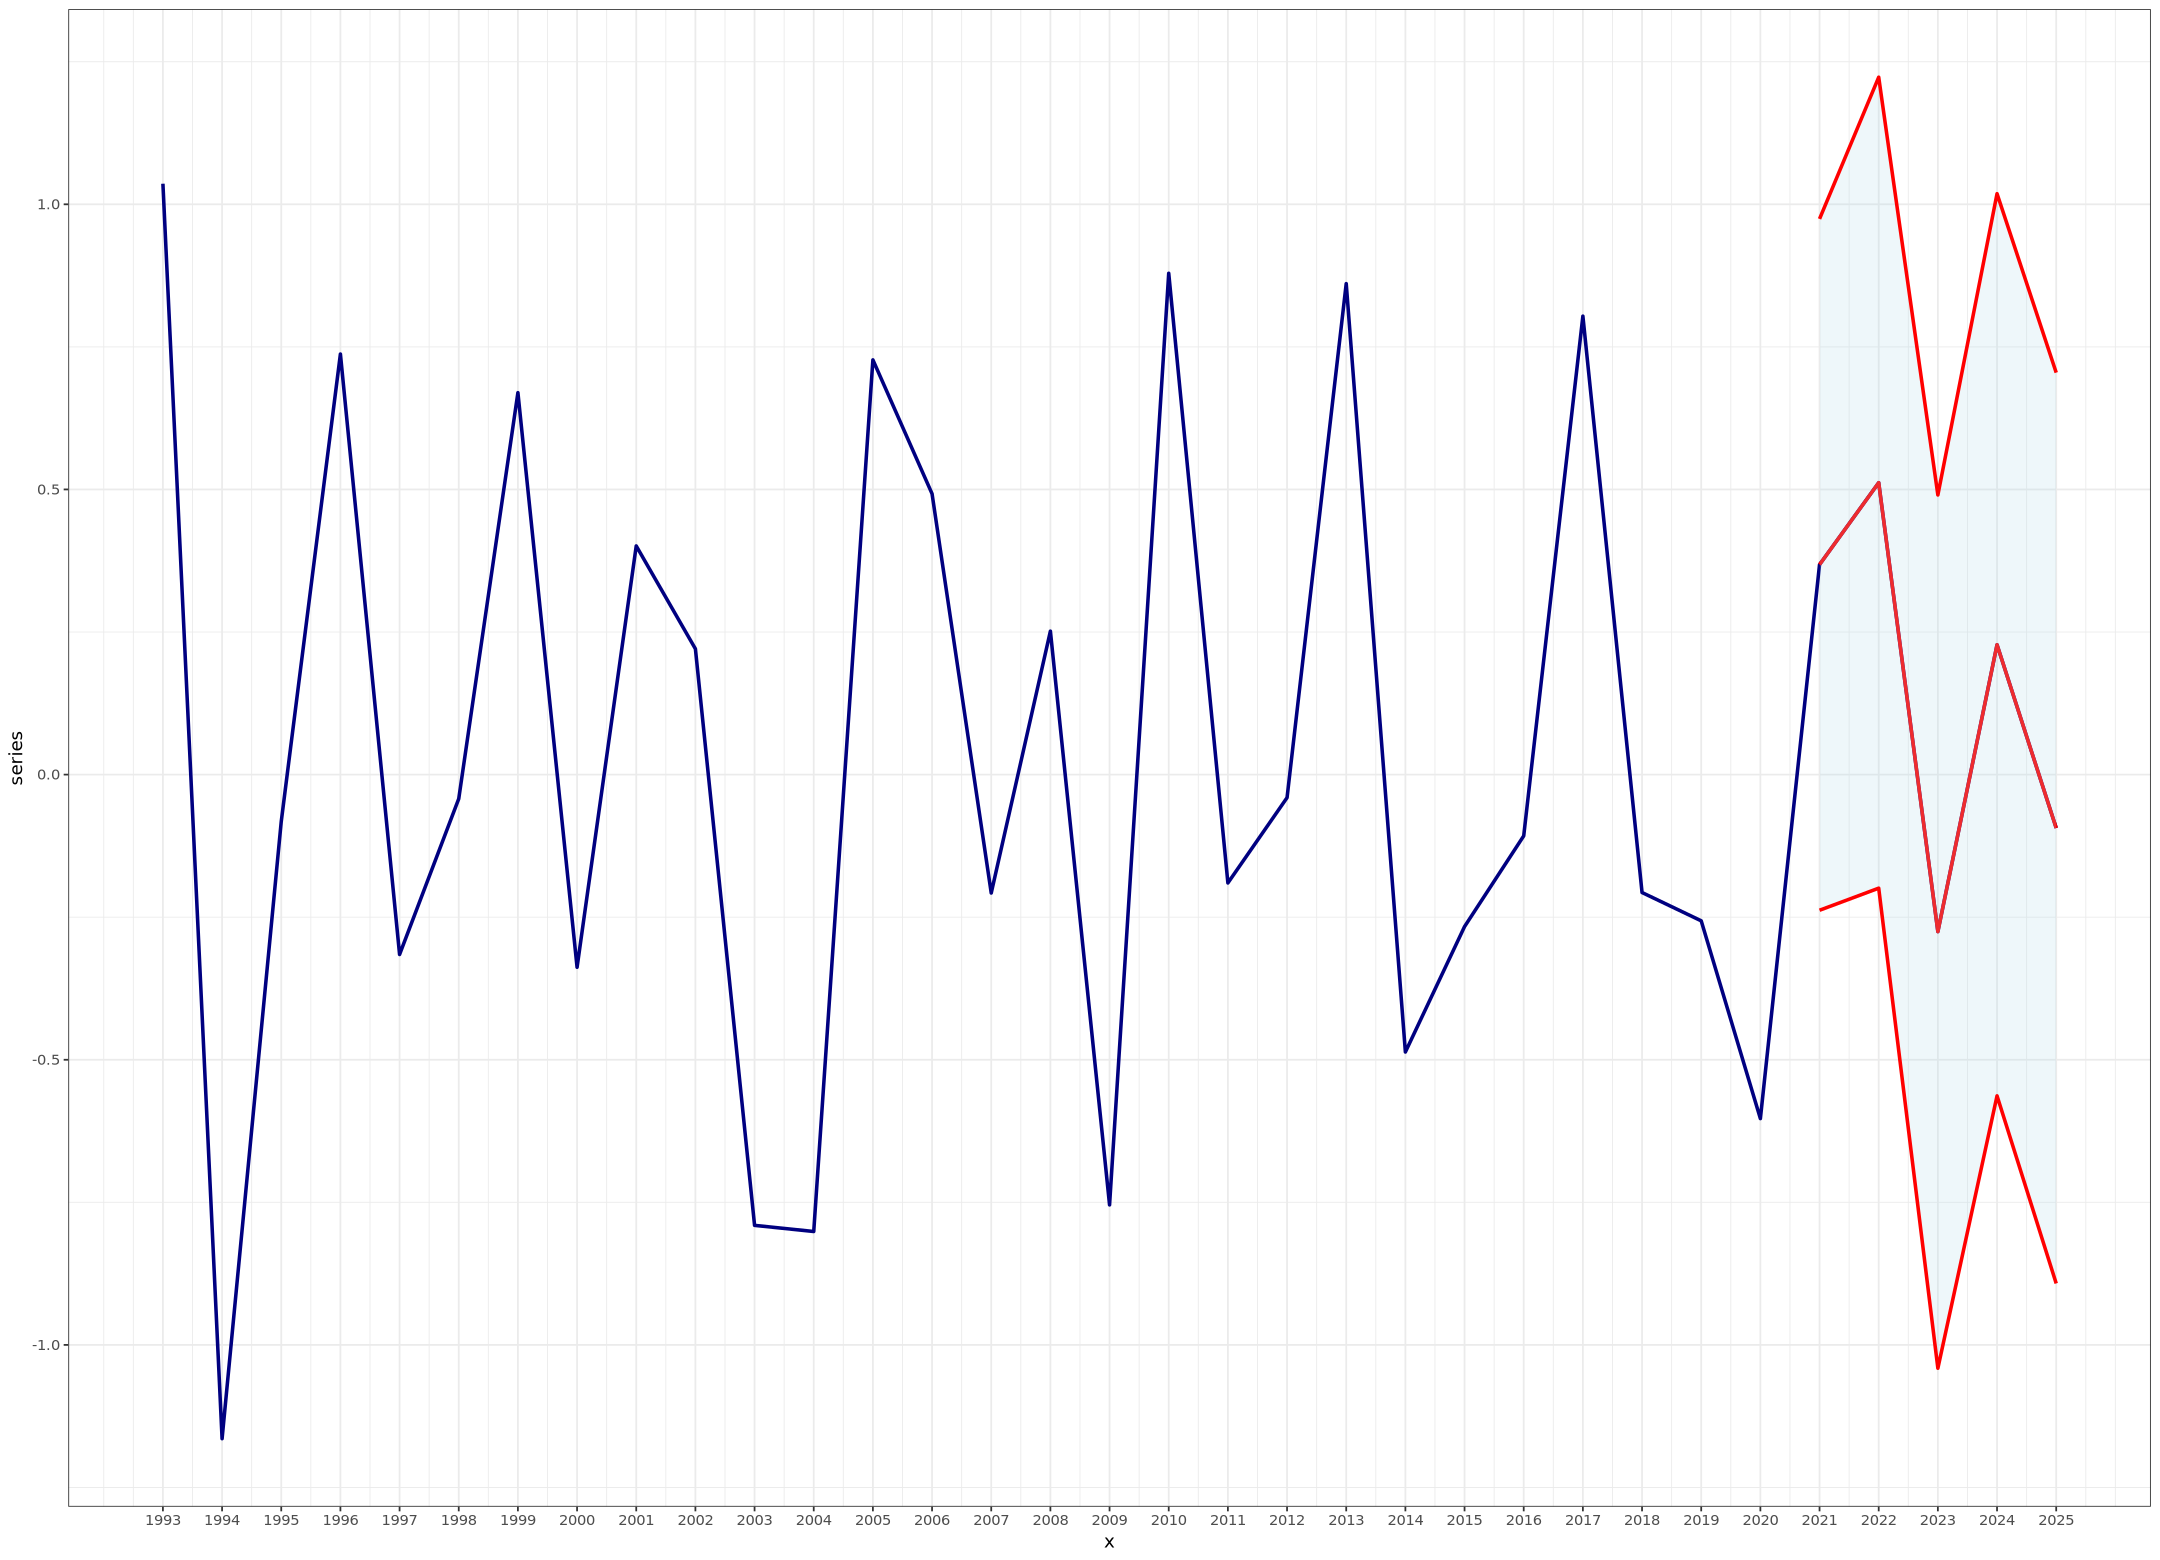

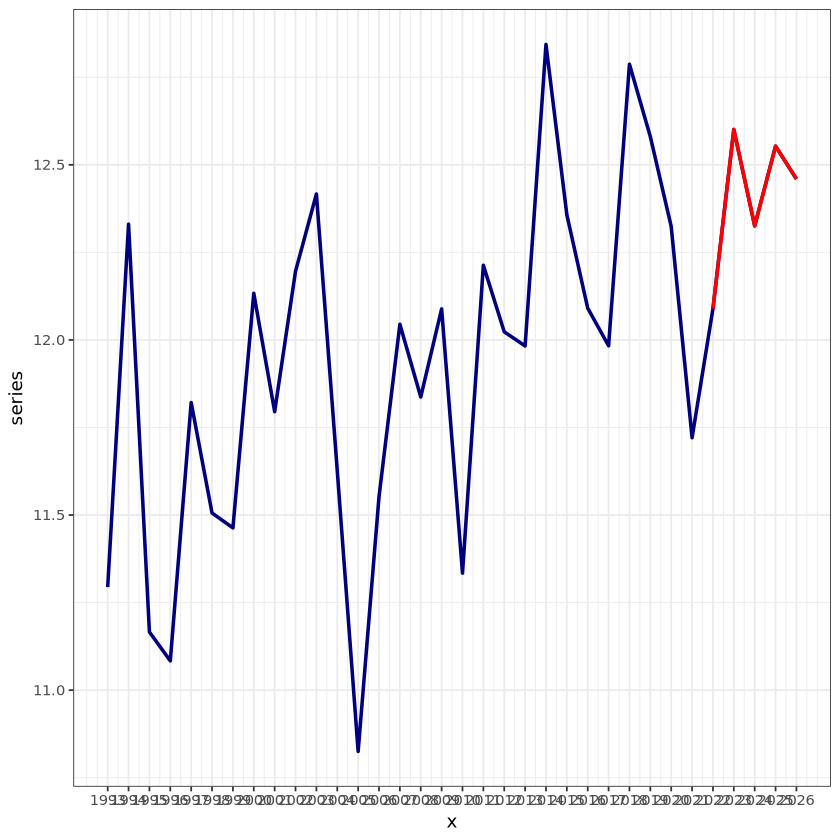

In [85]:
plot_forecast(ts_data, prediction, test = FALSE)
options(repr.plot.width = 7, repr.plot.height = 7)
ts_data_non_stationary <- yearly_dataset$MED_mean
plot_forecast_non_stationary(ts_data_non_stationary, prediction, test = FALSE)

Series: timeseries 
ARIMA(2,1,2)(1,1,1)[12] 

Coefficients:
          ar1     ar2      ma1      ma2     sar1     sma1
      -0.6512  0.1208  -0.1409  -0.8591  -0.0721  -0.9182
s.e.   0.1034  0.0617   0.0879   0.0875   0.0611   0.0431

sigma^2 = 1.705:  log likelihood = -578.46
AIC=1170.91   AICc=1171.26   BIC=1197.61

Training set error measures:
                       ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.004848648 1.269737 1.010934 -38.82432 68.70866 0.2764524
                   ACF1
Training set -0.0146538


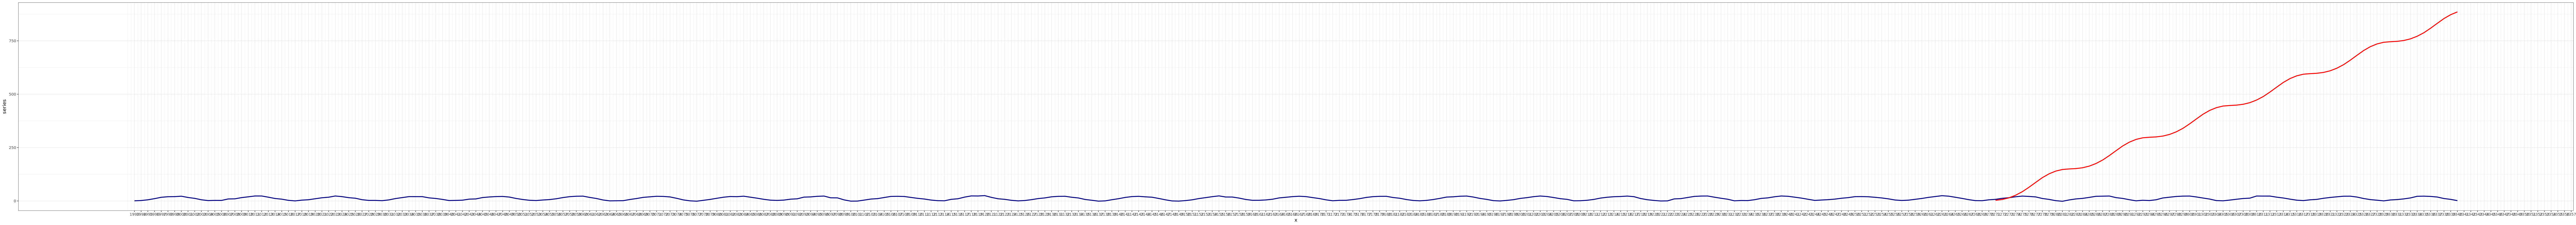

In [64]:
ts_data <- (monthly_dataset$MED_mean)
options(repr.plot.width = 80, repr.plot.height = 7)
best_arima<-find_best_sarima_model(timeseries = ts_data,seasonal_period = 12,iterations = 5)